予約と訪問のデータを使用して、将来の日付のレストランへの訪問者の総数を予測することが求められます

このコンペティションはホットペッパーと「Airレジ（飲食店向けPOSレジアプリ）」予約と訪問のデータを利用して、将来の日付のレストランへの訪問者の総数を予測するものです。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
from sklearn import preprocessing

air_reserve = pd.read_csv(r"/../air_reserve.csv")
air_visit_data = pd.read_csv(r"/../air_visit_data.csv")
date_info = pd.read_csv(r"/../date_info.csv").rename(columns={'calendar_date':'visit_date'})
air_store_info = pd.read_csv(r"/../air_store_info.csv")
store_id_relation = pd.read_csv(r"/../store_id_relation.csv")
hpg_reserve = pd.read_csv(r"/../hpg_reserve.csv")
hpg_store_info = pd.read_csv(r"/../hpg_store_info.csv")
sub = pd.read_csv(r"/../sample_submission.csv")

目的関数...visitors

学習データの期間は2016/1/1....2017/4/22

テストデータの期間は2017/4/23....2017/5/31

kaggleでのデータ内容の確認

1.air_reserve.csv...Airレジ経由の予約情報

air_store_id – Airレジ固有のレストランID

visit_datetime – 予約時のお店訪問予定時間

reserve_datetime – 予約をした時の時間

reserve_visitors – 予約人数

2.hpg_reserve.csv...ホットペッパー経由の予約情報

hpg_store_id – ホットペッパー固有のレストランID

visit_datetime – 予約時のお店訪問予定時間

reserve_datetime – 予約をした時の時間

reserve_visitors – 予約人数

3.air_store_info.csv...Airレジのレストラン情報

air_store_id – Airレジ固有ID

air_genre_name – レストランのジャンル

air_area_name – レストランの所属エリア

latitude – 緯度

longitude – 経度

4.hpg_store_info.csv...ホットペッパーのレストラン情報

hpg_store_id – ホットペッパー固有ID

air_genre_name – レストランのジャンル

air_area_name – レストランの所属エリア

latitude – 緯度

longitude – 経度

5.store_id_relation.csv...AirレジとホットペッパーのIDリレーション,両サービスを使っているお店のみ

hpg_store_id – ホットペッパー固有ID

air_store_id – Airレジ固有ID

6.air_visit_data.csv...Airレジの各レストランの日付ごとの実客数

air_store_id – AirレジID
visit_date – 日付
visitors – 実客数

7.sample_submission.csv...提出ファイルのサンプルフィーマット予測しなくてはいけない日付も入っている
idの項目など少し特徴がある

id – air_store_idとvisit_dateを連結させたid

visitors – 予想客数（店＆日付のコンビネーション）

8.data_info.csv

カレンダー日付の基本的な情報

day_of_week - 曜日

holiday_flg - 週末かどうかのフラグ

In [5]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [6]:
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [8]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [9]:
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [10]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [12]:
date_info.head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [13]:
sub.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [29]:
def missing_values(df):
    mis_val = df.isnull().sum()
    return mis_val

In [31]:
missing_values(air_reserve)

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [32]:
missing_values(air_visit_data)

air_store_id    0
visit_date      0
visitors        0
dtype: int64

In [33]:
missing_values(air_store_info)

air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64

In [34]:
missing_values(hpg_store_info)

hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64

In [35]:
missing_values(store_id_relation)

air_store_id    0
hpg_store_id    0
dtype: int64

In [36]:
missing_values(date_info)

visit_date     0
day_of_week    0
holiday_flg    0
dtype: int64

In [37]:
missing_values(sub)

id          0
visitors    0
dtype: int64

欠損値はなし

２. 仮説を立てる

単純に人口が多い地域は母数が多いので来客者数が多くなると考えられる

時間帯では昼食時、夜に人が集中すると考えられる。

料理ジャンルは日本なので日本食・・・と言いたいところだが、日本食は高級店のイメージが強い。
多くの人は居酒屋などの大衆料理店を利用するだろうと考えられる。

当然、祝日は人が集中すると考えられる。特にクリスマスは。

3. データの可視化

In [38]:
reserve_copy = air_reserve.copy()

In [39]:
reserve_copy["visit_datetime"] = pd.to_datetime(reserve_copy["visit_datetime"])
reserve_copy["reserve_datetime"] = pd.to_datetime(reserve_copy["reserve_datetime"])
reserve_copy["visit_date"] = reserve_copy["visit_datetime"].dt.strftime("%Y-%m")
reserve_copy["visit_date"] = pd.to_datetime(reserve_copy["visit_date"])

In [40]:
reserve_copy["visit_months"] = reserve_copy["visit_datetime"].dt.strftime("%Y-%m")
reserve_copy["months"] = reserve_copy["reserve_datetime"].dt.month
reserve_copy["dow"] = reserve_copy["reserve_datetime"].dt.dayofweek
reserve_copy["date"] = reserve_copy["reserve_datetime"].dt.day
reserve_copy["Hour"] = reserve_copy["reserve_datetime"].dt.strftime("%H")

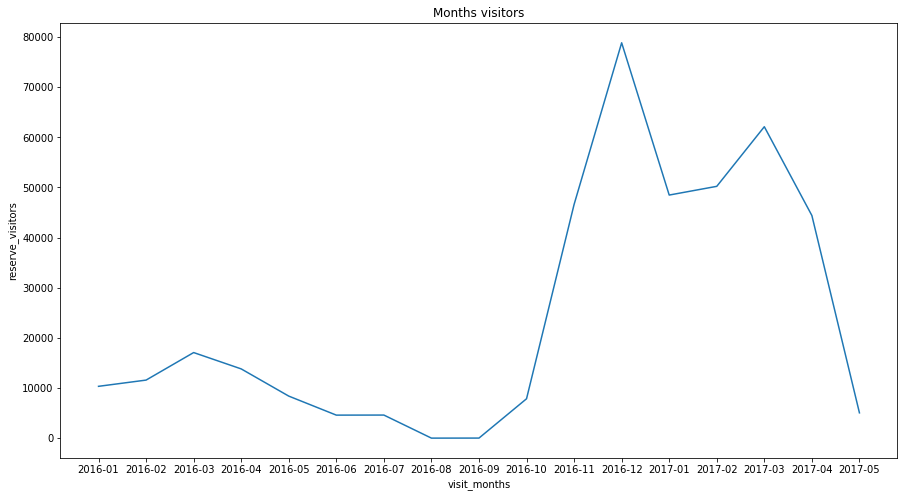

In [41]:
#air_reserveの月毎の予約人数を見てみる
Months_reserve = reserve_copy.groupby(["visit_months"])["reserve_visitors"].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.lineplot(x=Months_reserve["visit_months"], y=Months_reserve["reserve_visitors"], data=Months_reserve)
plt.title("Months visitors")
plt.show()

・推察

予約人数が8月,9月が異様に少ない
原因は来客数の問題ではく、元々のデータそのものの欠損であると思われる

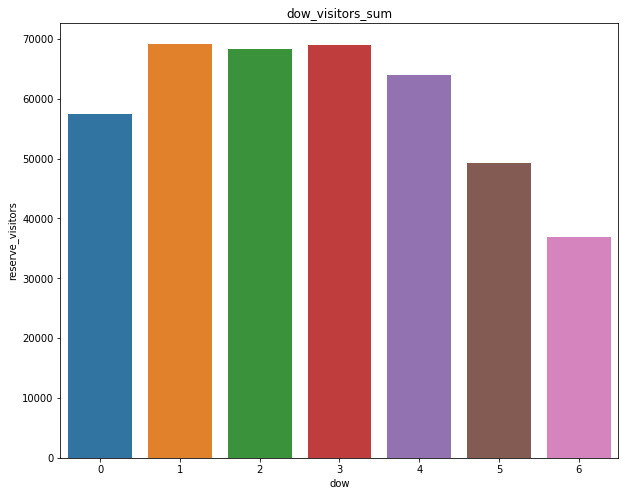

In [42]:
#air_reserveの曜日毎の予約者数
Dow_visitors = reserve_copy.groupby(["dow"])["reserve_visitors"].sum().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(x=Dow_visitors["dow"], y=Dow_visitors["reserve_visitors"], data=Dow_visitors)
plt.title("dow_visitors_sum")
plt.xlabel("dow")
plt.ylabel("reserve_visitors")
plt.show()

・推察

週末、休日は予約が多そうに見えるが意外と少ない

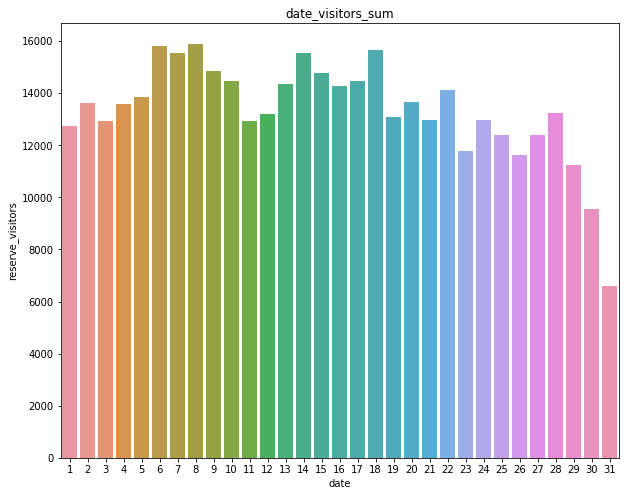

In [43]:
#日毎の予約人数
Day_visitors = reserve_copy.groupby(["date"])["reserve_visitors"].sum().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(x=Day_visitors["date"], y=Day_visitors["reserve_visitors"], data=Day_visitors)
plt.title("date_visitors_sum")
plt.xlabel("date")
plt.ylabel("reserve_visitors")
plt.show()

・推察
月末の数が少ない

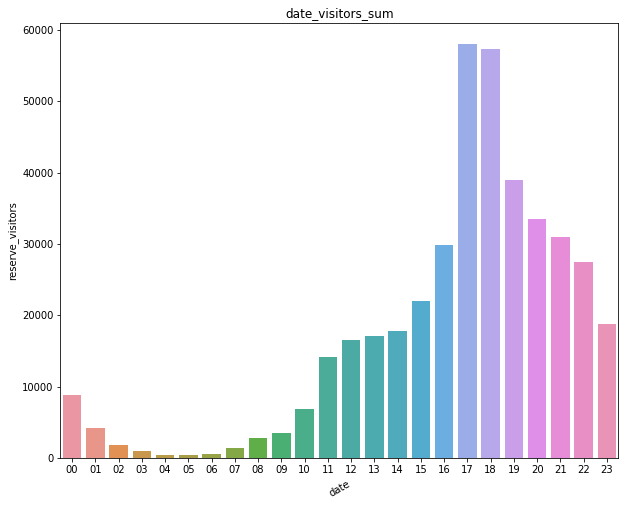

In [44]:
#時刻毎の予約人数
Hour_visitors = reserve_copy.groupby(["Hour"])["reserve_visitors"].sum().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(x=Hour_visitors["Hour"], y=Hour_visitors["reserve_visitors"], data=Hour_visitors)
plt.title("date_visitors_sum")
plt.xlabel("date", rotation=30)
plt.ylabel("reserve_visitors")
plt.show()

・推察

これは予想通り、仕事終わりの夕方に夕食や飲みに行く人が多いため予約件数が集中する

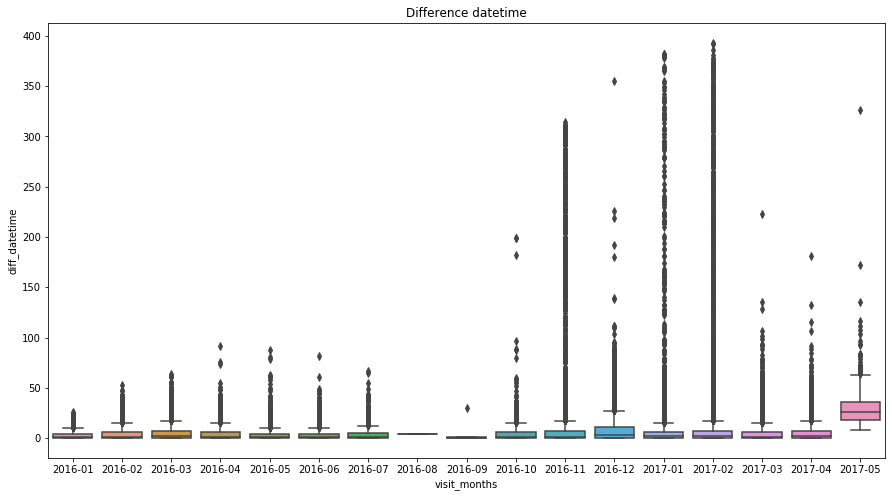

In [45]:
#予約時間と来店時間の差
reserve_copy["diff_datetime"] =  reserve_copy["visit_datetime"] - reserve_copy["reserve_datetime"]
reserve_copy["diff_datetime"] = reserve_copy["diff_datetime"].dt.days

plt.figure(figsize=(15, 8))
sns.boxplot(x=reserve_copy["visit_months"], y=reserve_copy["diff_datetime"], data=reserve_copy)
plt.title("Difference datetime")
plt.show()

・推察

多くの場合は2日以内には予約してから来客している

In [47]:
#先と同じようにコピーを取り、データ型の変換、そして年月日の算出
hpg_reserve_copy = hpg_reserve.copy()

hpg_reserve_copy["visit_datetime"] = pd.to_datetime(hpg_reserve_copy["visit_datetime"])
hpg_reserve_copy["reserve_datetime"] = pd.to_datetime(hpg_reserve_copy["reserve_datetime"])

hpg_reserve_copy["visit_months"] = hpg_reserve_copy["visit_datetime"].dt.strftime("%Y-%m")
hpg_reserve_copy["months"] = hpg_reserve_copy["reserve_datetime"].dt.month
hpg_reserve_copy["dow"] = hpg_reserve_copy["reserve_datetime"].dt.dayofweek
hpg_reserve_copy["date"] = hpg_reserve_copy["reserve_datetime"].dt.day
hpg_reserve_copy["Hour"] = hpg_reserve_copy["reserve_datetime"].dt.strftime("%H")

hpg_reserveの可視化

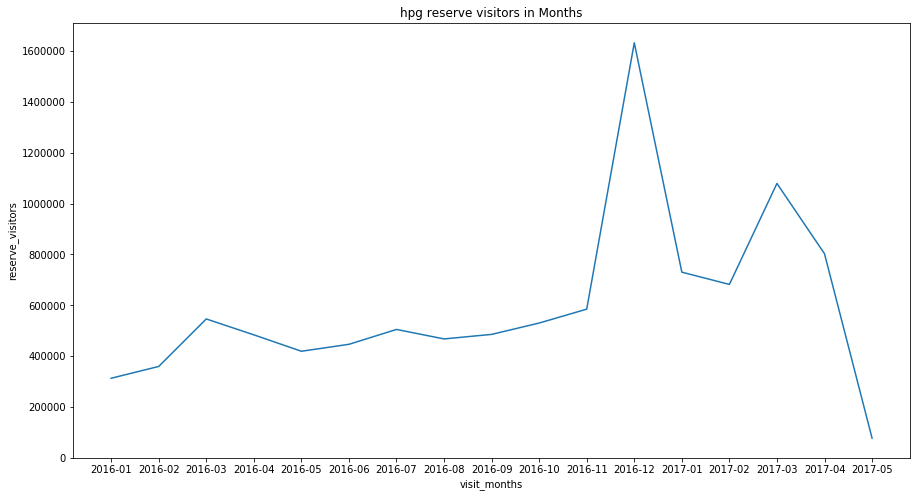

In [48]:
#月毎の予約人数
hpg_visitors = hpg_reserve_copy.groupby(["visit_months"])["reserve_visitors"].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.lineplot(x=hpg_visitors["visit_months"], y=hpg_visitors["reserve_visitors"], data=hpg_visitors)
plt.title("hpg reserve visitors in Months")
plt.show()

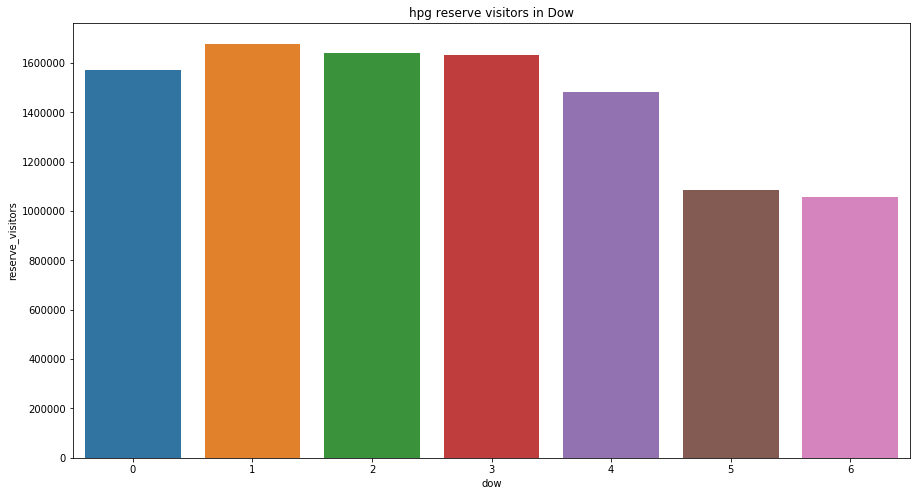

In [49]:
#曜日毎の予約人数
hpg_dow = hpg_reserve_copy.groupby(["dow"])["reserve_visitors"].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(x=hpg_dow["dow"], y=hpg_dow["reserve_visitors"], data=hpg_dow)
plt.title("hpg reserve visitors in Dow")
plt.show()

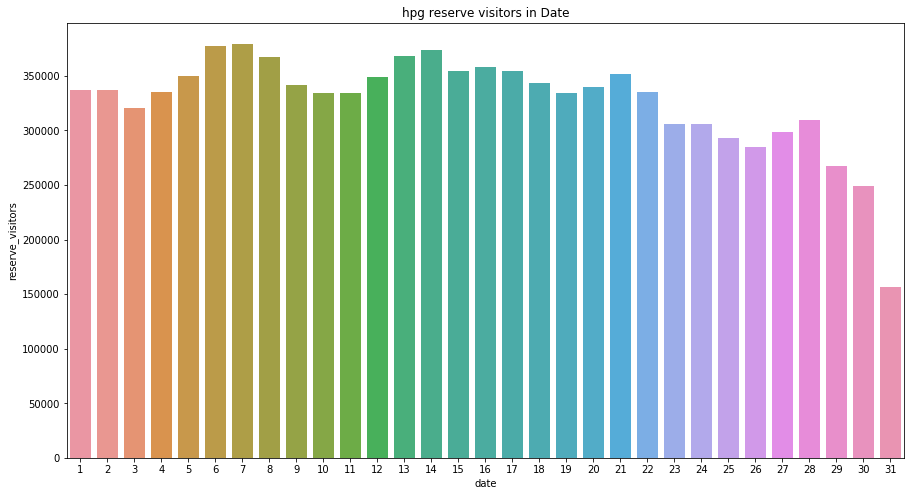

In [50]:
#日毎の予約人数
hpg_date = hpg_reserve_copy.groupby(["date"])["reserve_visitors"].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(x=hpg_date["date"], y=hpg_date["reserve_visitors"], data=hpg_date)
plt.title("hpg reserve visitors in Date")
plt.show()

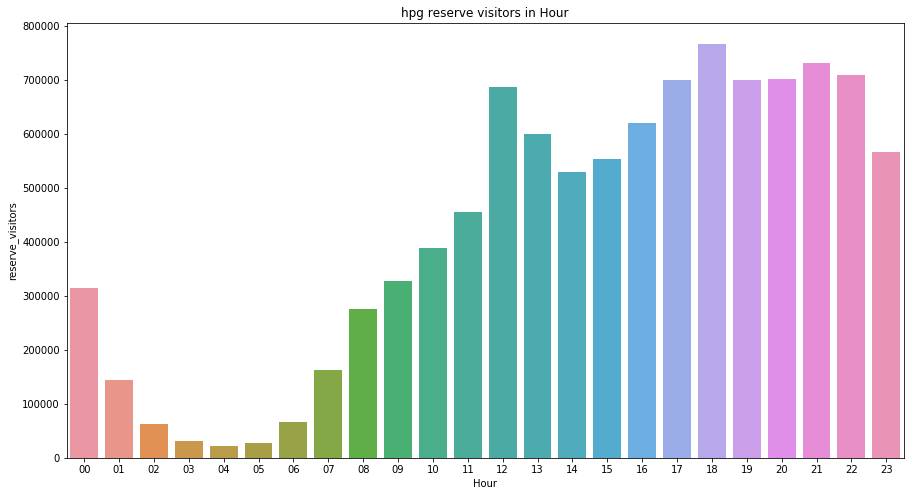

In [51]:
#時刻毎の予約者数
hpg_Hour = hpg_reserve_copy.groupby(["Hour"])["reserve_visitors"].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(x=hpg_Hour["Hour"], y=hpg_Hour["reserve_visitors"], data=hpg_Hour)
plt.title("hpg reserve visitors in Hour")
plt.show()

・推察

傾向はAirレジとほぼ同じ。

air_visit_dataの可視化

In [52]:
visit_copy = air_visit_data.copy()
visit_copy["visit_date"] = pd.to_datetime(visit_copy["visit_date"])
visit_copy["visit_months"] = visit_copy["visit_date"].dt.strftime("%Y-%m")
visit_copy["dow"] = visit_copy["visit_date"].dt.dayofweek
visit_copy["date"] = visit_copy["visit_date"].dt.day

In [53]:
#air_reserveとair_visit_dataの結合
visit_merge = pd.merge(visit_copy, reserve_copy[["air_store_id", "visit_date", "reserve_visitors", "visit_months"]], on=["air_store_id", "visit_date", "visit_months"], how="left")

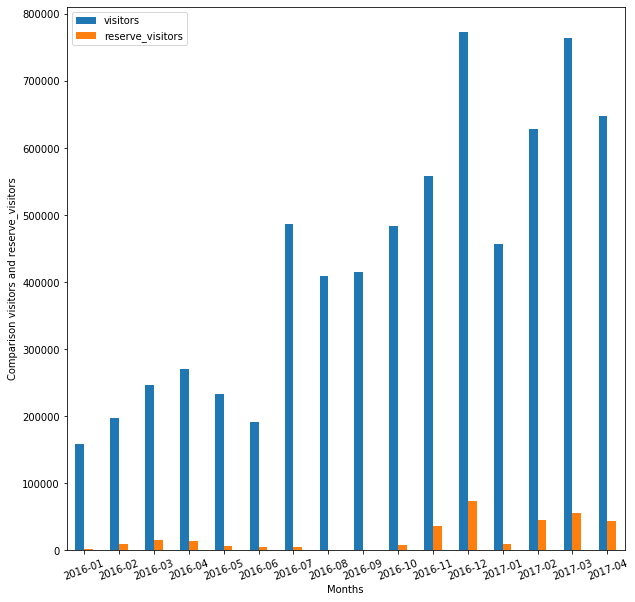

In [54]:
#予約者と実際の来客数の比較
comp_visitors = visit_merge.groupby(["visit_months"])[["visitors", "reserve_visitors"]].sum().reset_index().set_index(["visit_months"])

comp_visitors.plot.bar(figsize=(10, 10), rot=20)
plt.xlabel("Months")
plt.ylabel("Comparison visitors and reserve_visitors")
plt.show()

・推察

忘年会や卒業シーズンに予約が多い
当然ながら事前に予約して入店する客よりも通常の来客者の方が多い

air_store_infoの可視化

In [56]:
air_store_copy = air_store_info.copy()

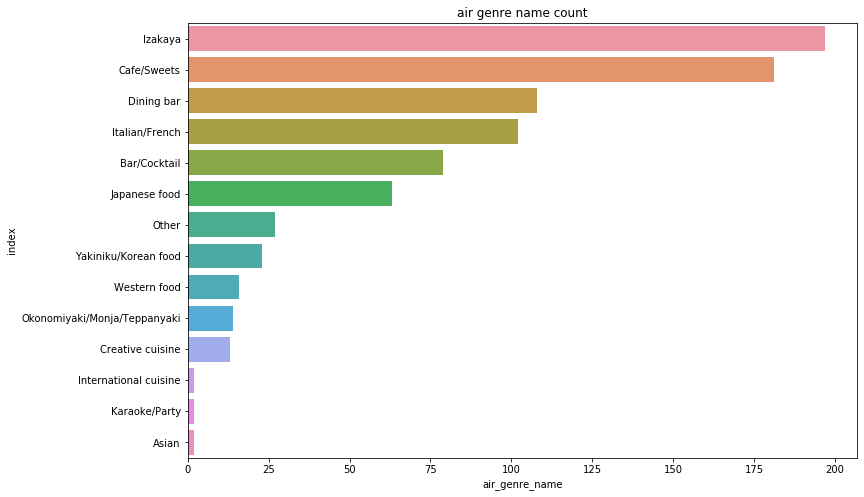

In [59]:
#店舗の料理のジャンル数
genre_count = air_store_copy["air_genre_name"].value_counts().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x=genre_count["air_genre_name"], y=genre_count["index"],  data=genre_count)
plt.title("air genre name count")
plt.show()

・推察

居酒屋やカフェが多くを占める

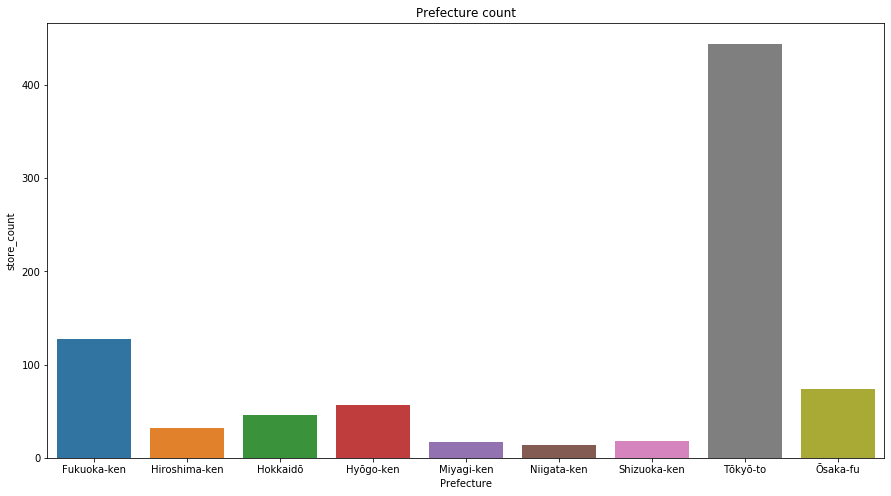

In [60]:
#エリアを市町村毎に分割する 県名
air_store_copy["Prefecture"] = air_store_copy["air_area_name"].map(lambda x: str(x).split(' ')[0])

Pre_store = air_store_copy.groupby(["Prefecture"])["air_store_id"].count().reset_index().rename(columns={"air_store_id":"store_count"})

plt.figure(figsize=(15, 8))
sns.barplot(x=Pre_store["Prefecture"], y=Pre_store["store_count"], data=Pre_store)
plt.title("Prefecture count")
plt.show()

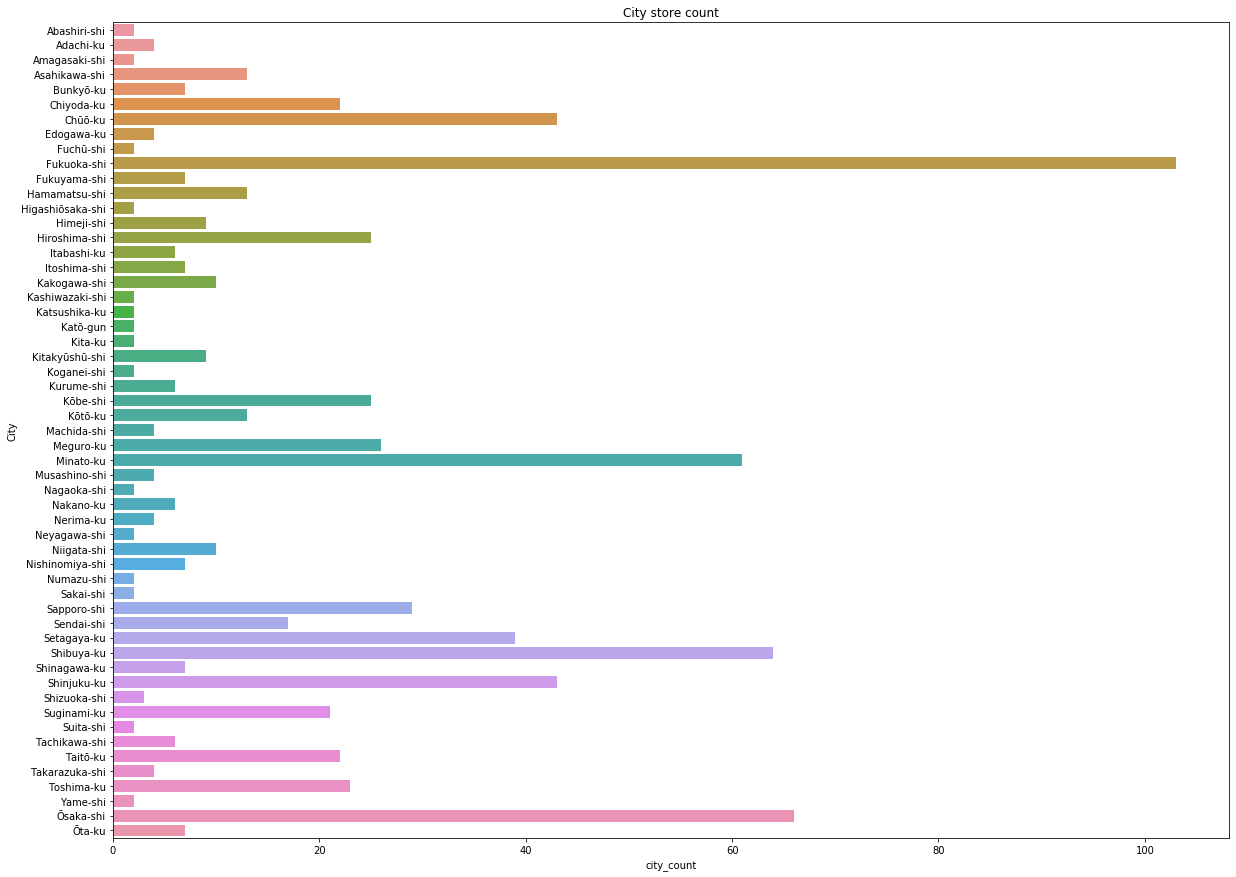

In [61]:
#City...市、区
air_store_copy["City"] = air_store_copy["air_area_name"].map(lambda x: str(x).split(' ')[1])
City_store = air_store_copy.groupby(["City"])["air_store_id"].count().reset_index().rename(columns={"air_store_id":"city_count"})

plt.figure(figsize=(20, 15))
sns.barplot(x=City_store["city_count"], y=City_store["City"], data=City_store)
plt.title("City store count")
plt.show()

・推察

東京は区で分かれているので県名では一番多かったが、分散している。
しかし、港区や新宿区などはそれなりに多い。
その次は福岡市や大阪市が多いことが分かる。大都市に店舗が集中している

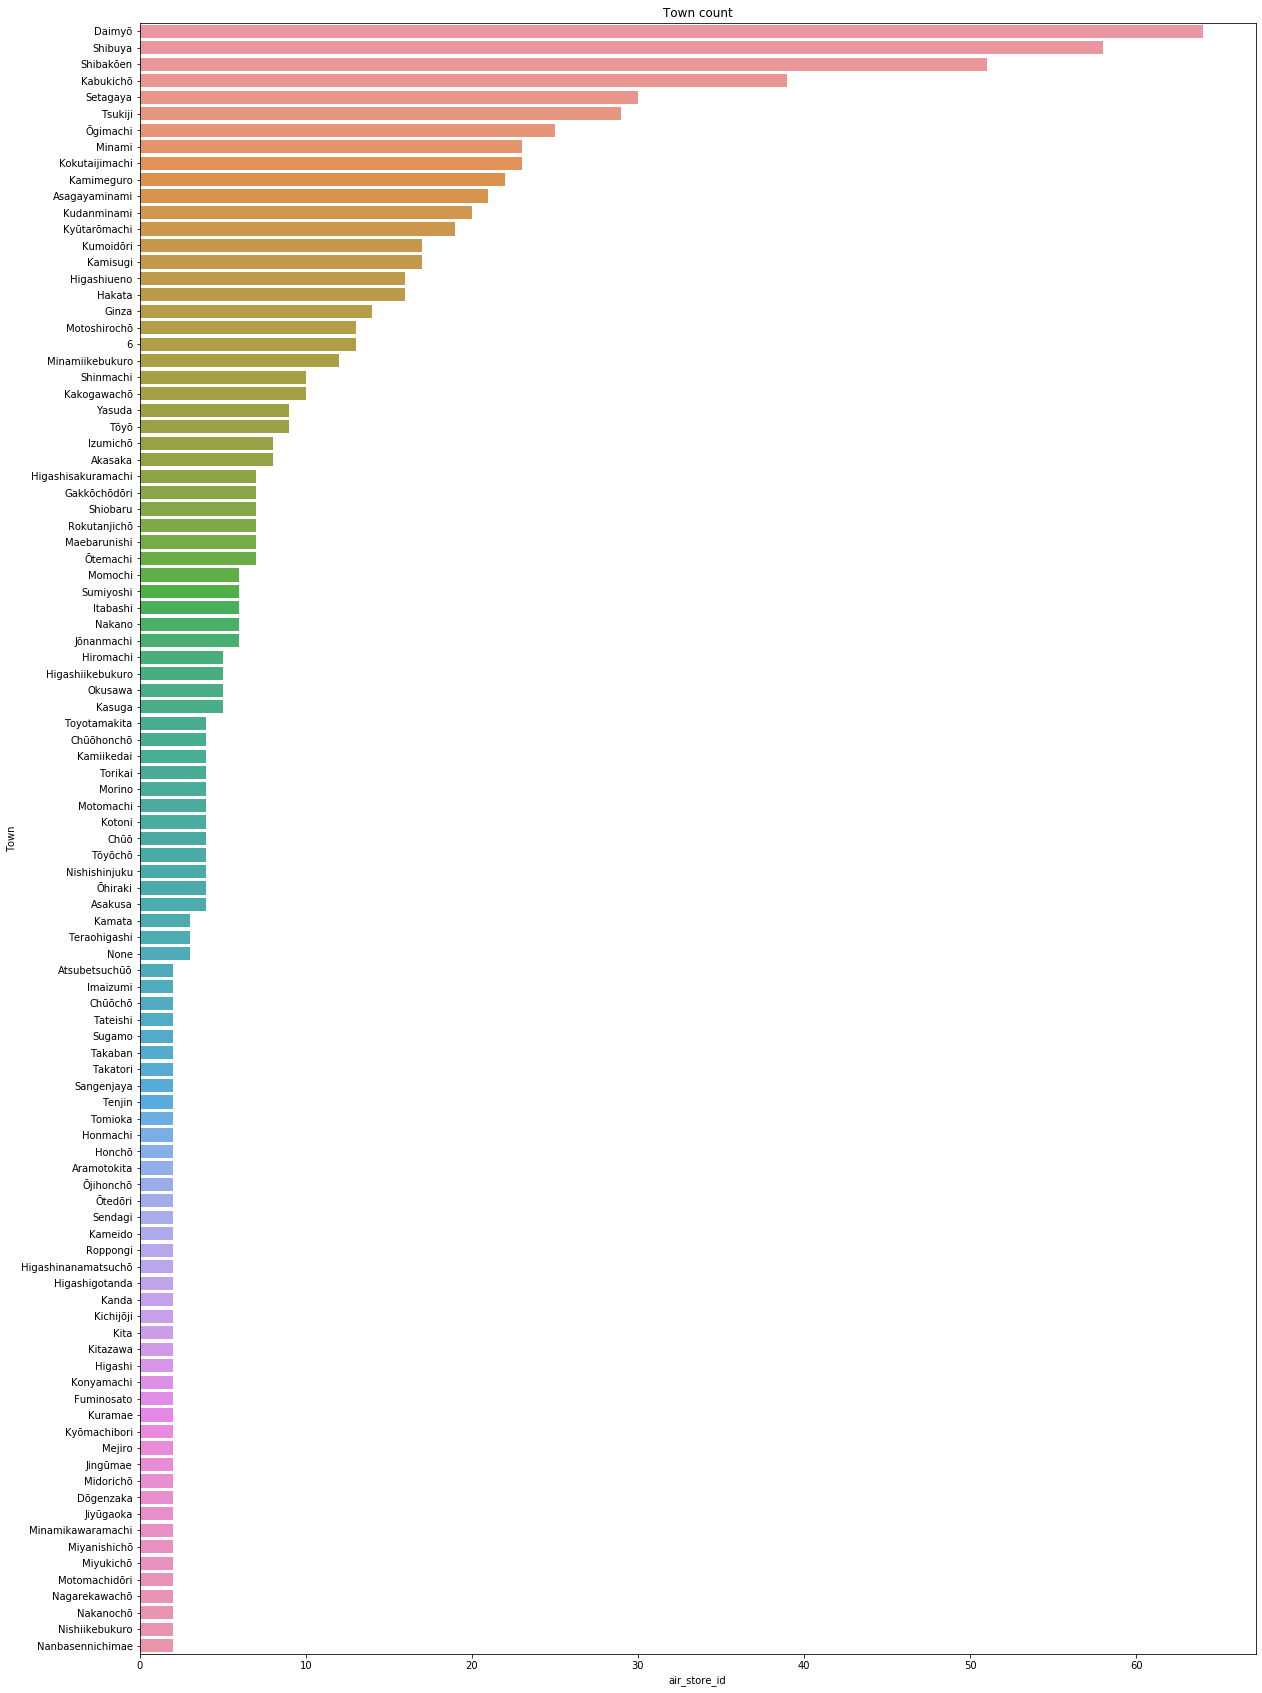

In [63]:
air_store_copy["Town"] = air_store_copy["air_area_name"].map(lambda x: str(x).split(' ')[2])
village_store = air_store_copy.groupby(["Town"])["air_store_id"].count().reset_index().sort_values("air_store_id", ascending=False)

plt.figure(figsize=(20, 30))
sns.barplot(x=village_store["air_store_id"], y=village_store["Town"], data=village_store)
plt.title("Town count")
plt.show()

・推察

Daimyo(大名)は福岡市, shibakoen(芝公園)は東京都。大都市の地名がほとんど

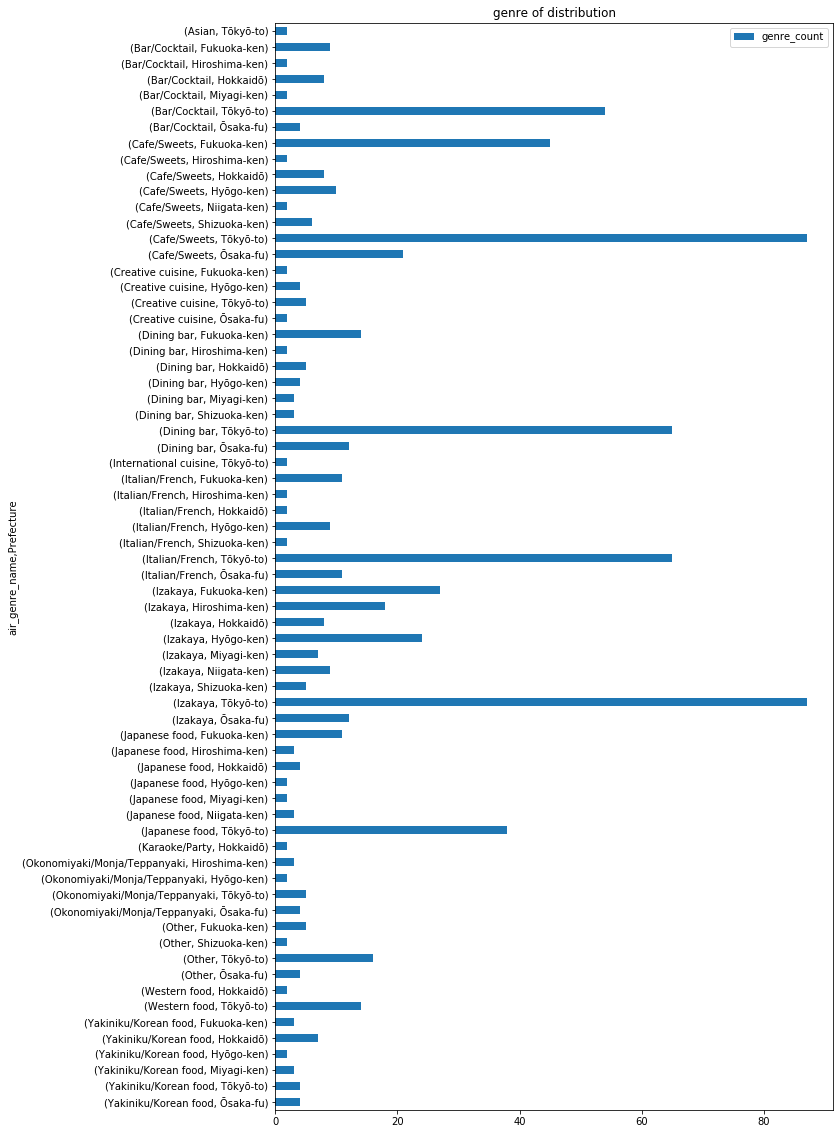

In [66]:
#エリア毎の料理のジャンルの分布
genre_dist = air_store_copy.groupby(["air_genre_name", "Prefecture"])["air_store_id"].count().reset_index().rename(columns={"air_store_id":"genre_count"}).set_index(["air_genre_name", "Prefecture"])

genre_dist.plot.barh(figsize=(10, 20))
plt.title("genre of distribution")
plt.show()

hpg_store_infoの可視化

In [67]:
hpg_store_copy = hpg_store_info.copy()

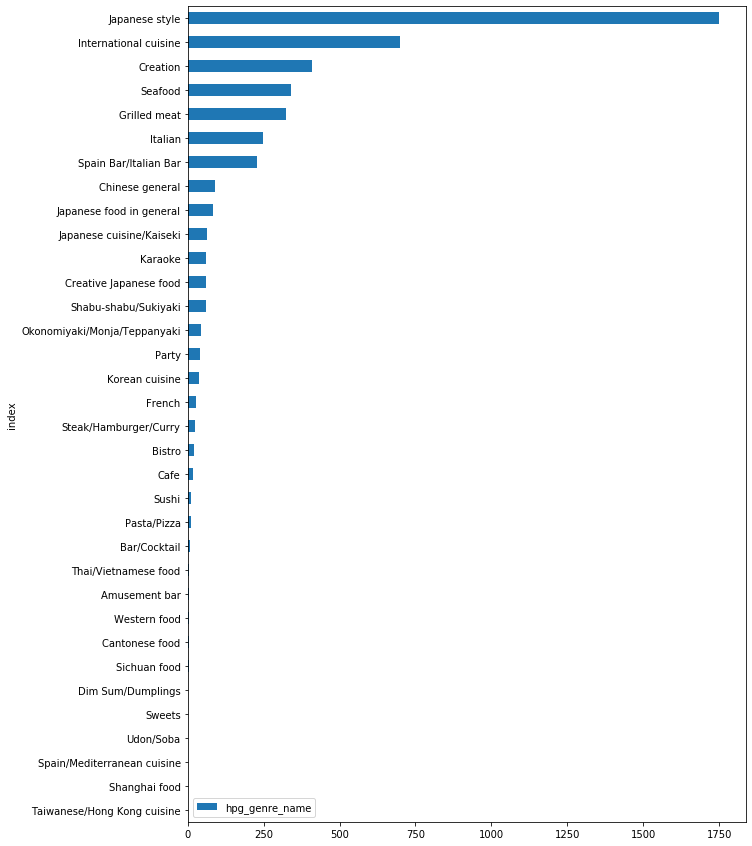

In [68]:
#hpg_store_infoの料理ジャンル毎の件数
df = hpg_store_copy["hpg_genre_name"].value_counts().reset_index().sort_values("hpg_genre_name", ascending=True).set_index(["index"])
df.plot.barh(figsize=(10, 15))
plt.show()

・推察

hpg_store_infoは更に詳細に料理ジャンルが分けられている。

air_genre_nameは14に対して、hpg_genre_nameは34のジャンルに分けられている。

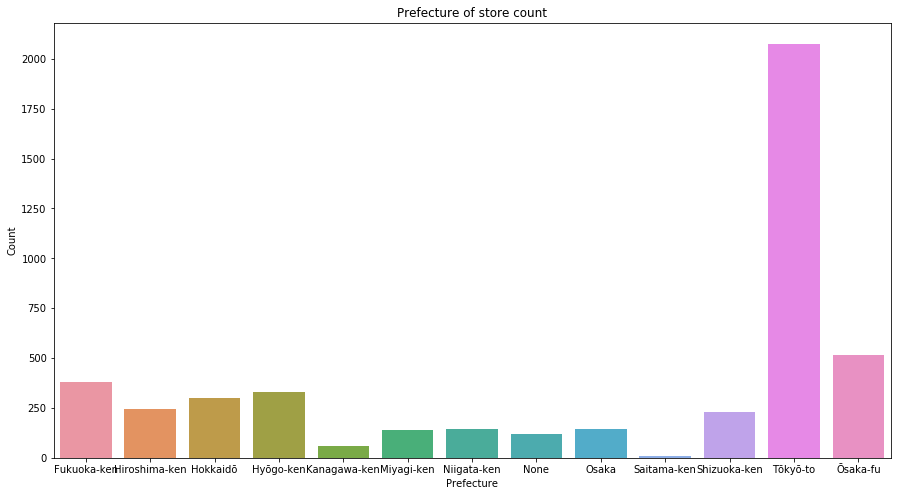

In [69]:
#Hpgの都道府県毎の店舗数
hpg_store_copy["Prefecture"] = hpg_store_copy["hpg_area_name"].map(lambda x: str(x).split(' ')[0])

df = hpg_store_copy.groupby(["Prefecture"])["hpg_store_id"].count().reset_index()
plt.figure(figsize=(15, 8))
sns.barplot(x=df["Prefecture"], y=df["hpg_store_id"], data=df)
plt.title("Prefecture of store count")
plt.xlabel("Prefecture")
plt.ylabel("Count")
plt.show()

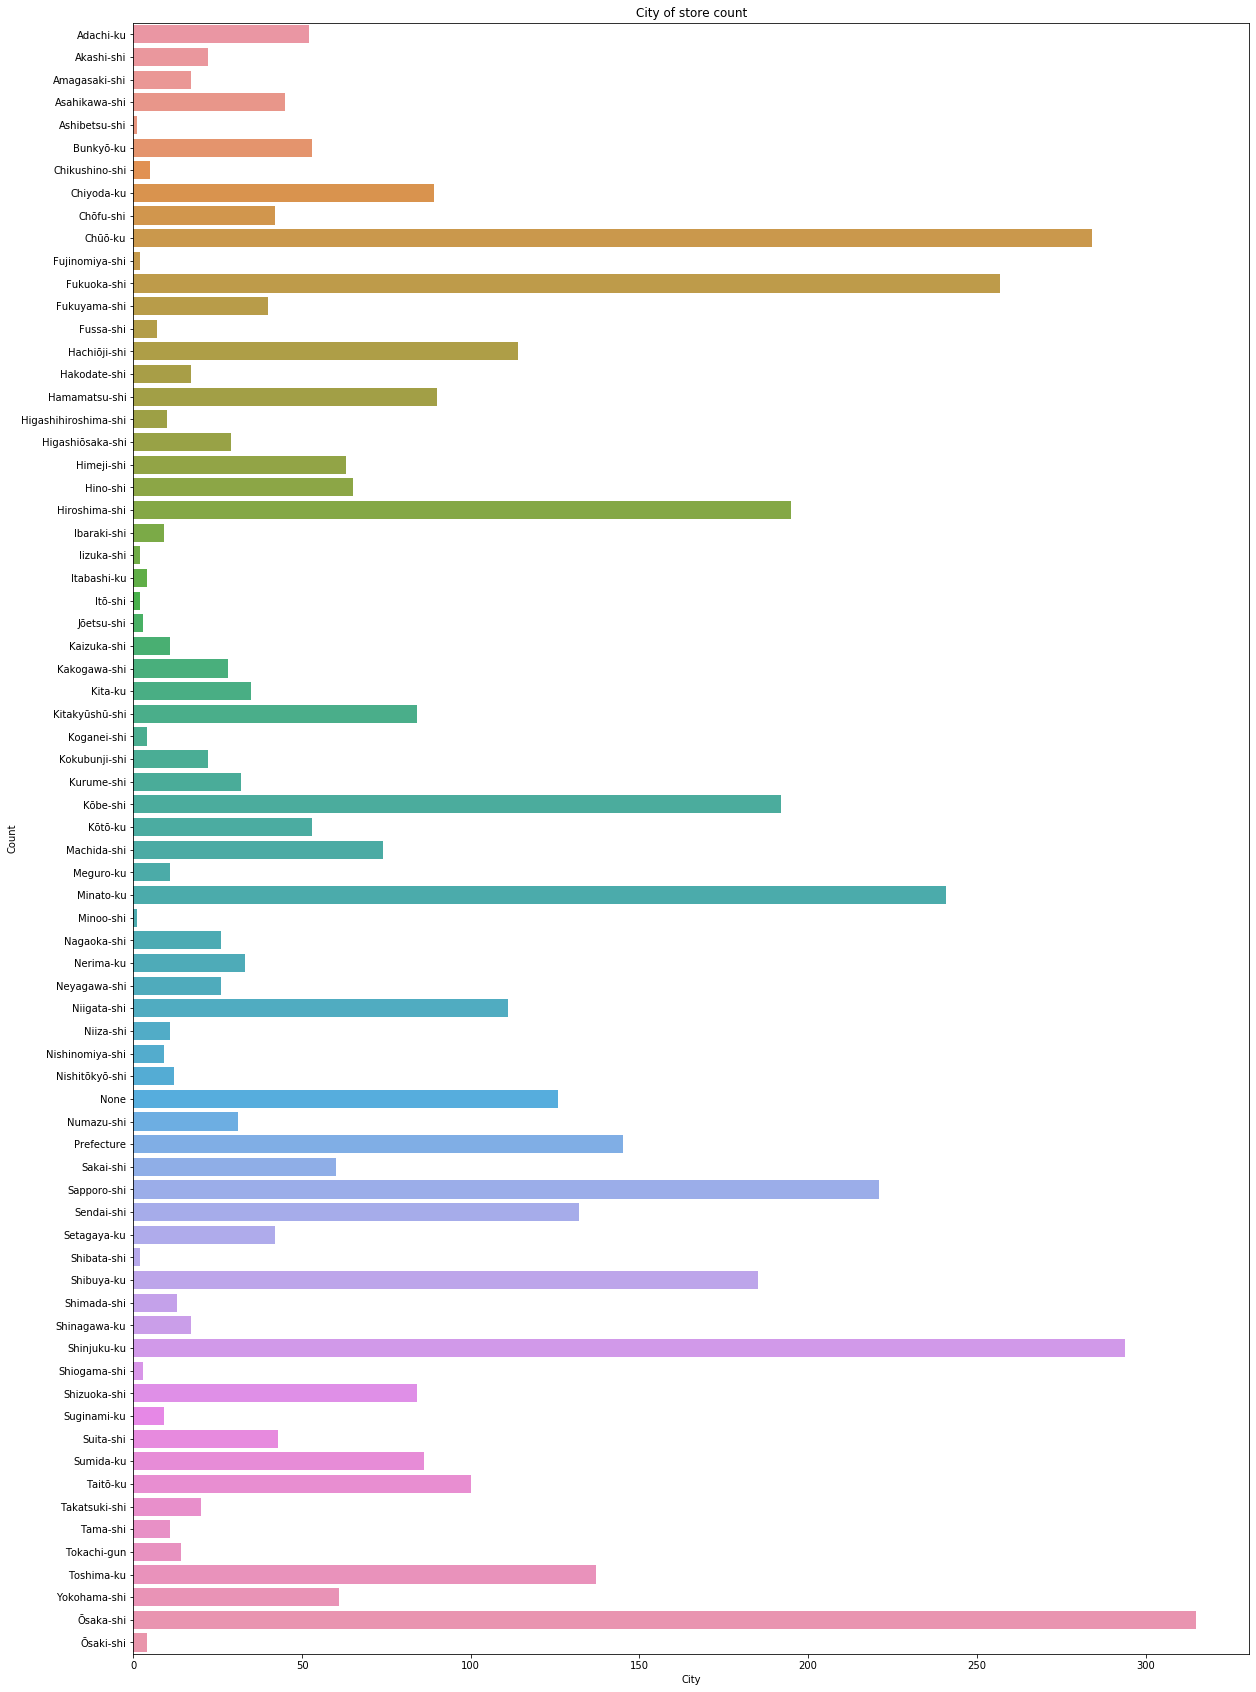

In [70]:
#市毎の店舗の個数
hpg_store_copy["City"] = hpg_store_copy["hpg_area_name"].map(lambda x: str(x).split(' ')[1])
df = hpg_store_copy.groupby(["City"])["hpg_store_id"].count().reset_index()

plt.figure(figsize=(20, 30))
sns.barplot(x=df["hpg_store_id"], y=df["City"], data=df)
plt.title("City of store count")
plt.xlabel("City")
plt.ylabel("Count")
plt.show()

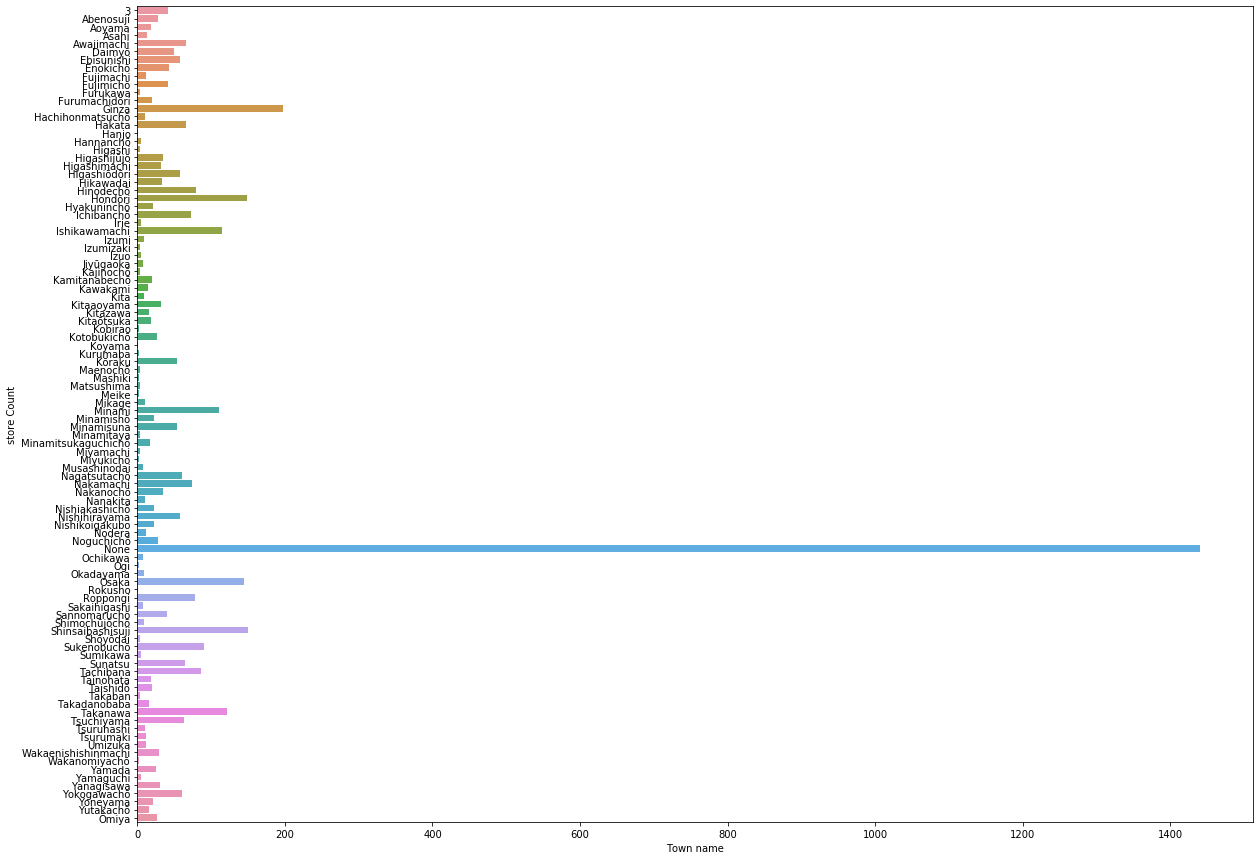

In [71]:
#町、村毎の店舗数
hpg_store_copy["Town"] = hpg_store_copy["hpg_area_name"].map(lambda x: str(x).split(' ')[2])
df = hpg_store_copy.groupby(["Town"])["hpg_store_id"].count().reset_index()

plt.figure(figsize=(20, 15))
sns.barplot(x=df["hpg_store_id"], y=df["Town"], data=df)
plt.xlabel("Town name")
plt.ylabel("store Count")
plt.show()

・推察

air_areaの時と傾向はほぼ変わらない

こちらもair_store_infoより詳細に分けられ、
町、村に該当する住所がない場合にNoneと表記されている

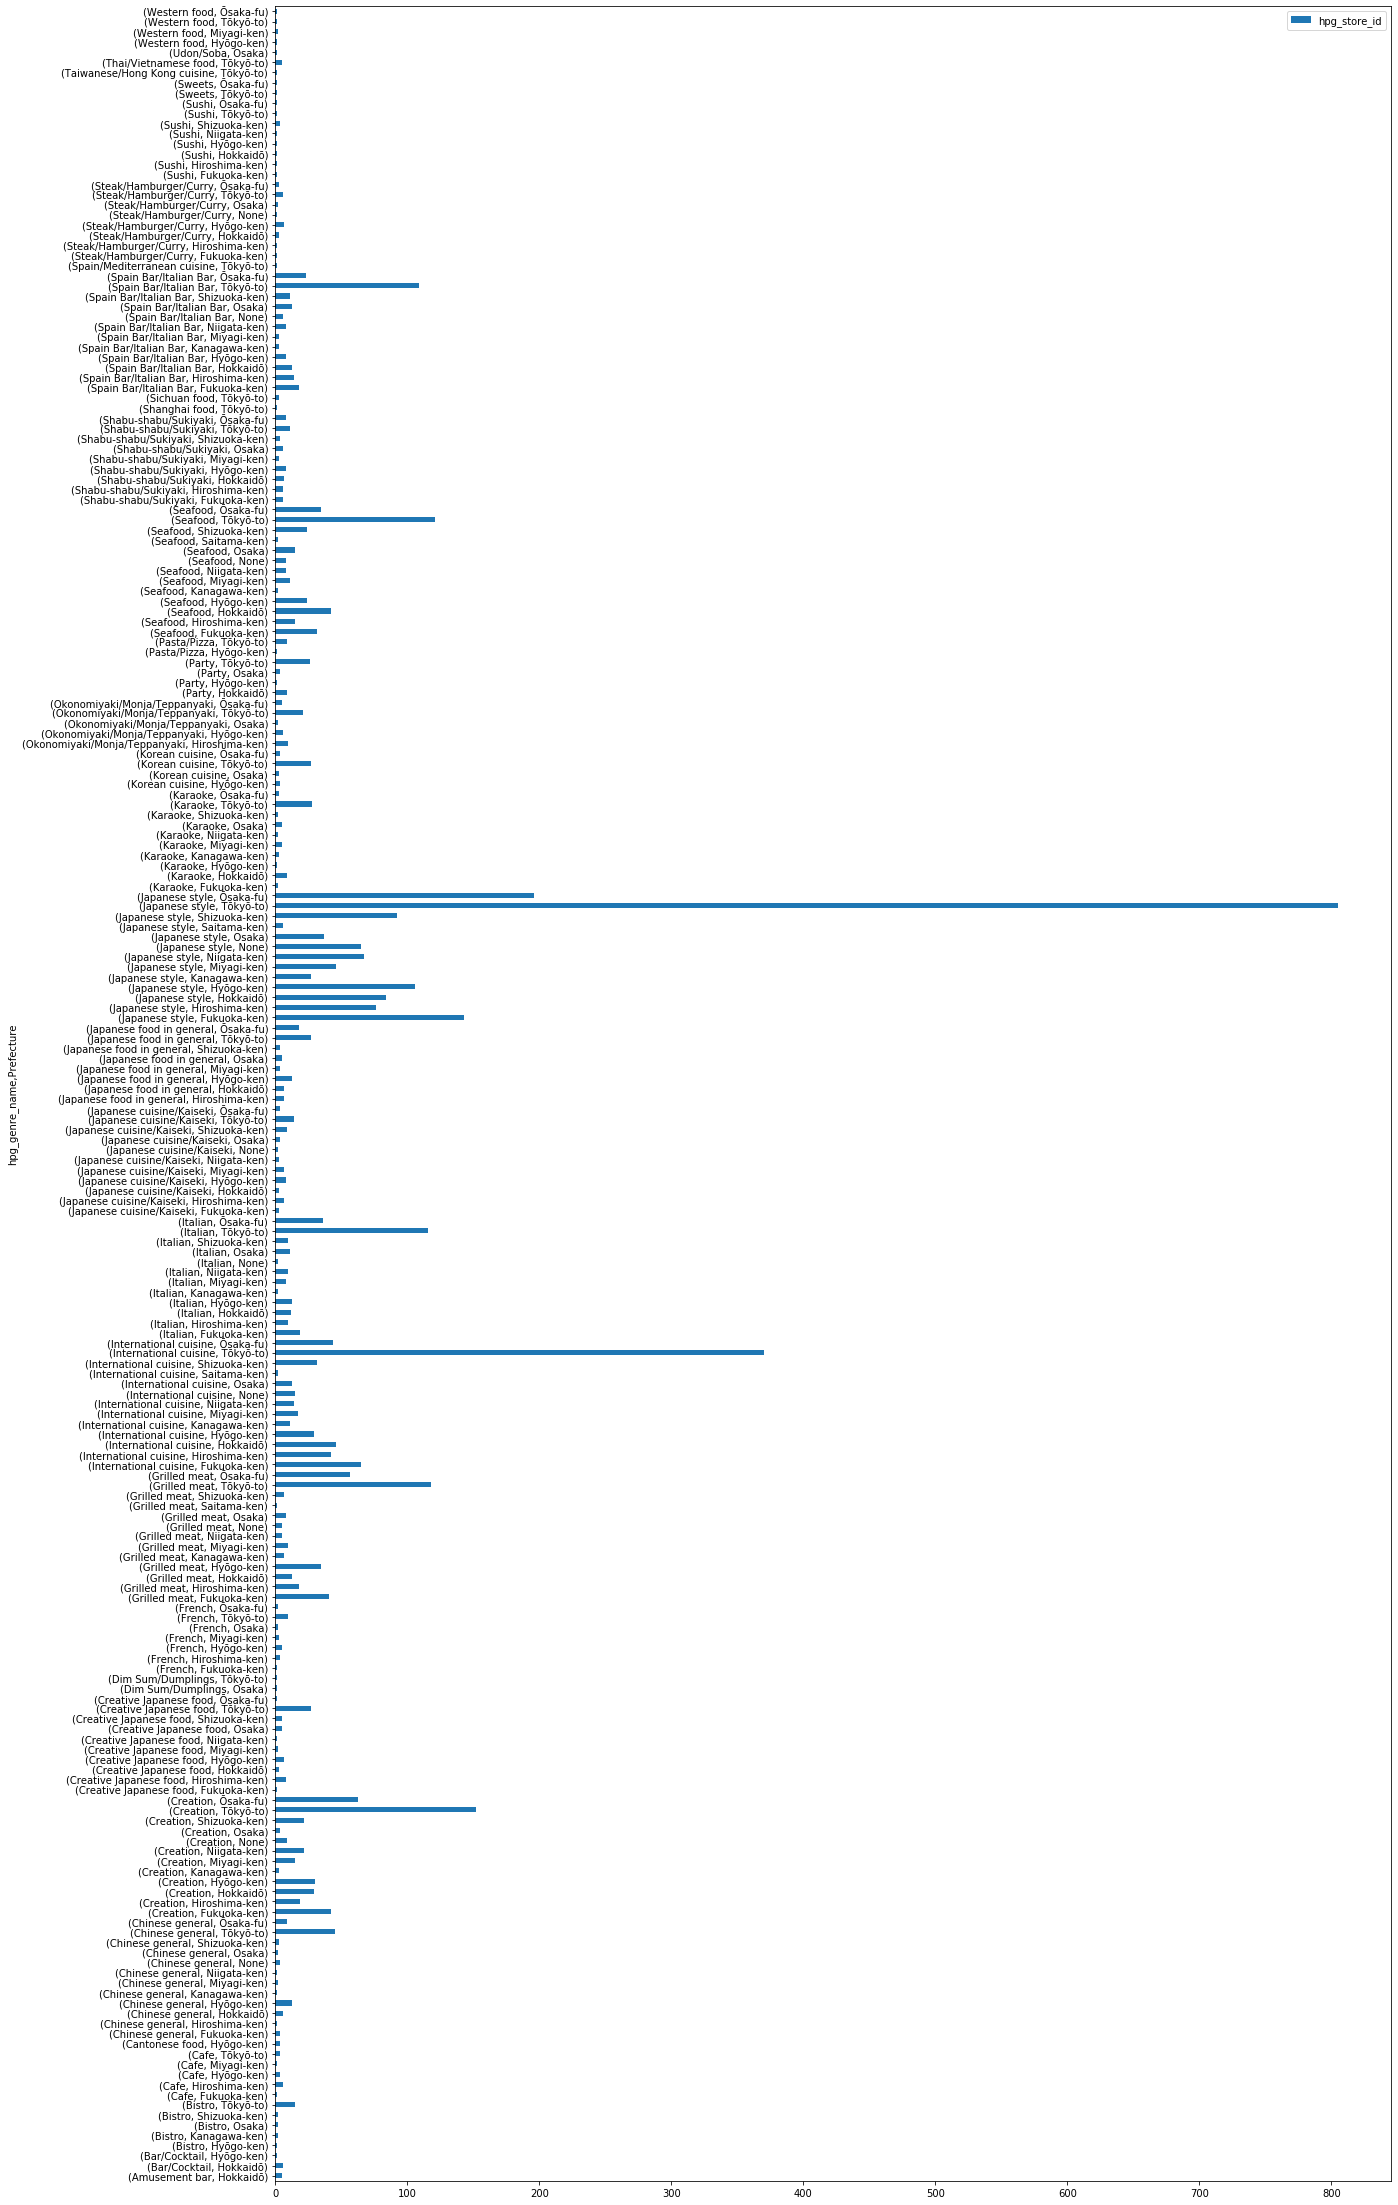

In [72]:
#エリア毎のジャンルの分布
df = hpg_store_copy.groupby(["hpg_genre_name", "Prefecture"])["hpg_store_id"].count().reset_index().set_index(["hpg_genre_name", "Prefecture"])

df.plot.barh(figsize=(20, 40))
plt.show()

date_infoの可視化

In [74]:
date_info.head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [75]:
date_info.query('holiday_flg == 1', engine="python")

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
10,2016-01-11,Monday,1
41,2016-02-11,Thursday,1
79,2016-03-20,Sunday,1
80,2016-03-21,Monday,1
119,2016-04-29,Friday,1
123,2016-05-03,Tuesday,1
124,2016-05-04,Wednesday,1


・推察

週末と祝日にフラグが立てられている

visit_mergeとair_store_infoをマージし、可視化する

In [77]:
visit_store_merge = pd.merge(visit_merge, air_store_copy, on=["air_store_id"], how="left")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


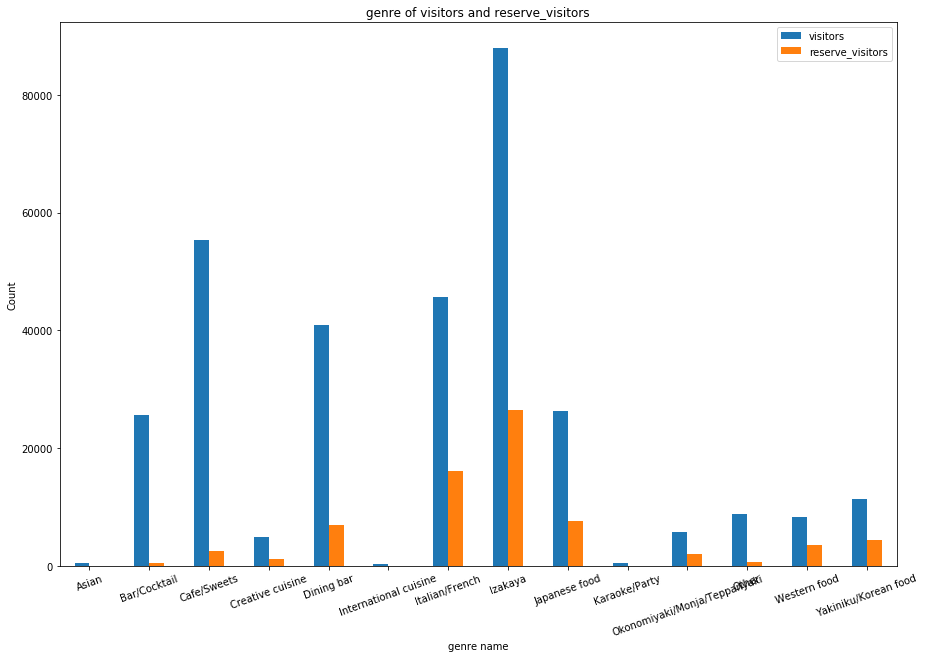

In [78]:
#料理のジャンル毎の予約者数と来客者数
df = visit_store_merge.groupby(["air_genre_name"])["visitors", "reserve_visitors"].count().reset_index().set_index(["air_genre_name"])

df.plot.bar(figsize=(15, 10), rot=20)
plt.title("genre of visitors and reserve_visitors")
plt.xlabel("genre name")
plt.ylabel("Count")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


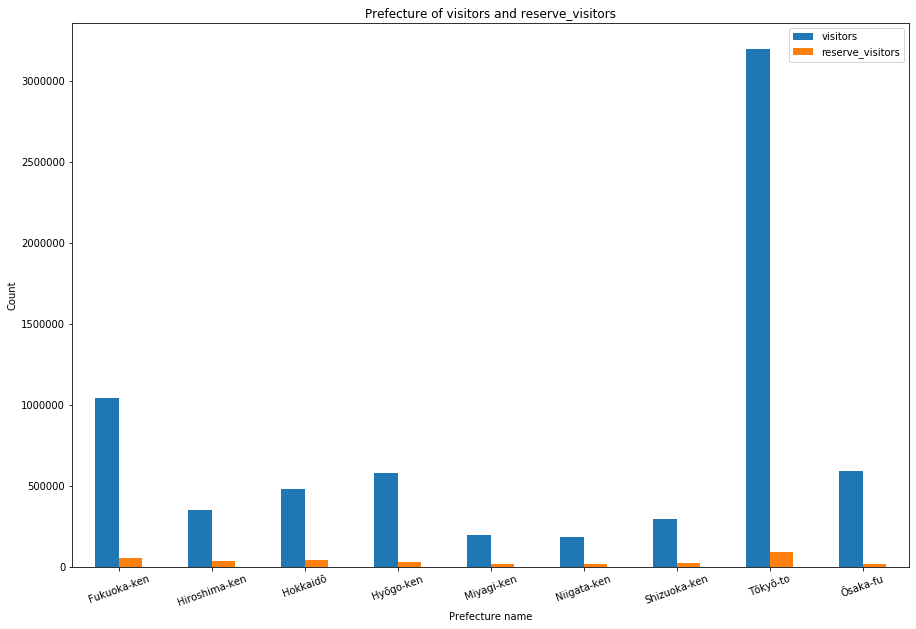

In [79]:
#都市毎の来客者、予約者数
df = visit_store_merge.groupby(["Prefecture"])["visitors", "reserve_visitors"].sum().reset_index().set_index(["Prefecture"])

df.plot.bar(figsize=(15, 10), rot=20)
plt.title("Prefecture of visitors and reserve_visitors")
plt.xlabel("Prefecture name")
plt.ylabel("Count")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


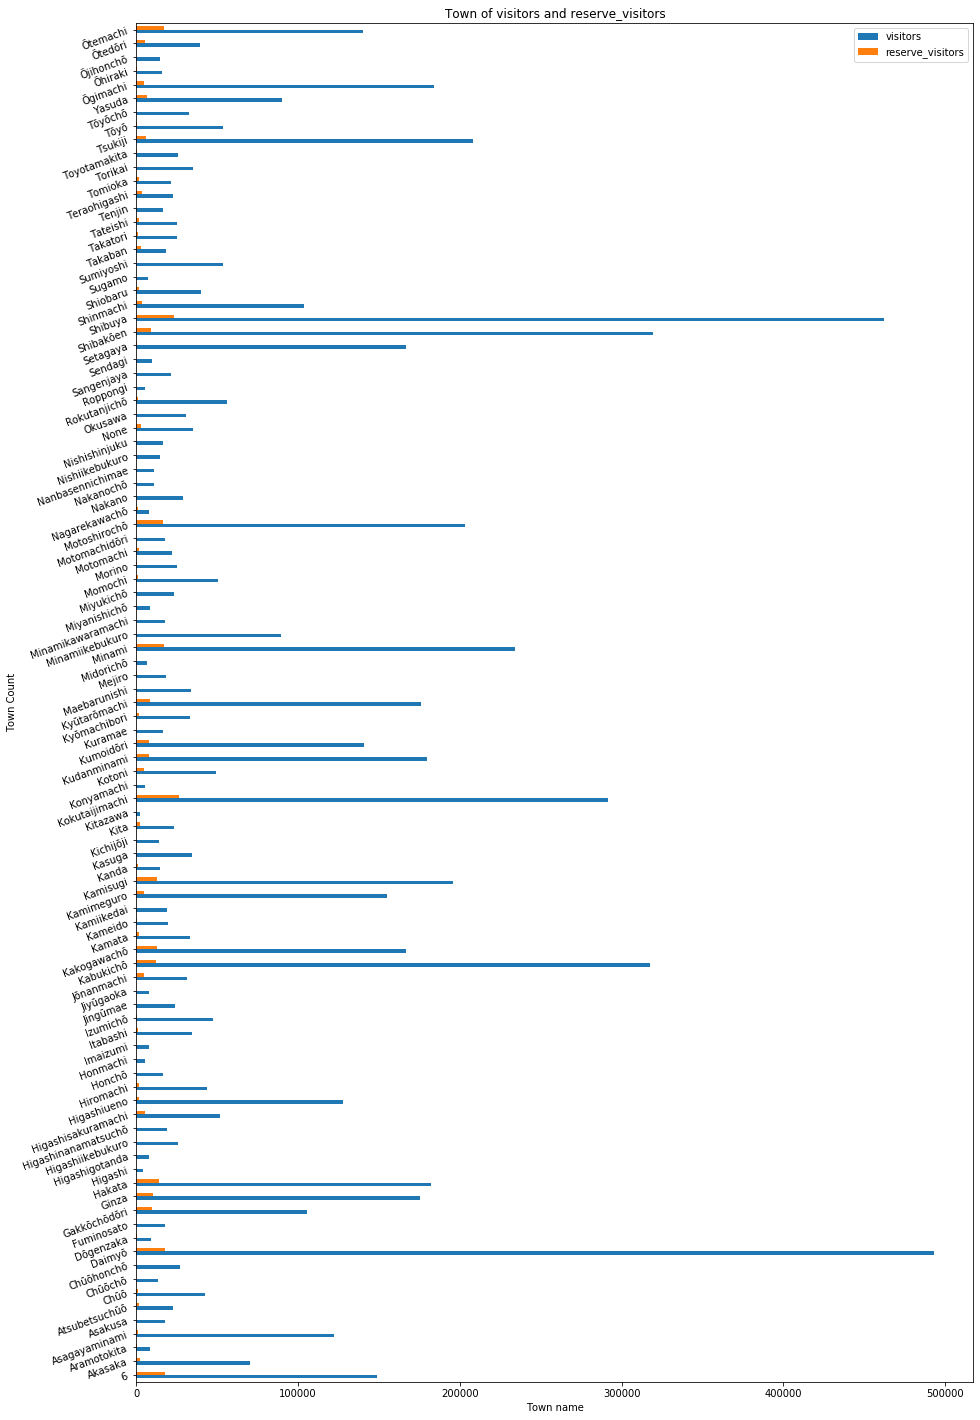

In [81]:
#町、村毎の予約者、来客者数
df = visit_store_merge.groupby(["Town"])["visitors", "reserve_visitors"].sum().reset_index().set_index(["Town"])

df.plot.barh(figsize=(15, 25), rot=20)
plt.title("Town of visitors and reserve_visitors")
plt.xlabel("Town name")
plt.ylabel("Town Count")
plt.show()

visit_mergeとhpg_store_copyをマージし、可視化する

In [82]:
x = pd.merge(store_id_relation, visit_merge, on=["air_store_id"], how="left")
hpg_store_merge = pd.merge(x, hpg_store_copy, on=["hpg_store_id"], how="left")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


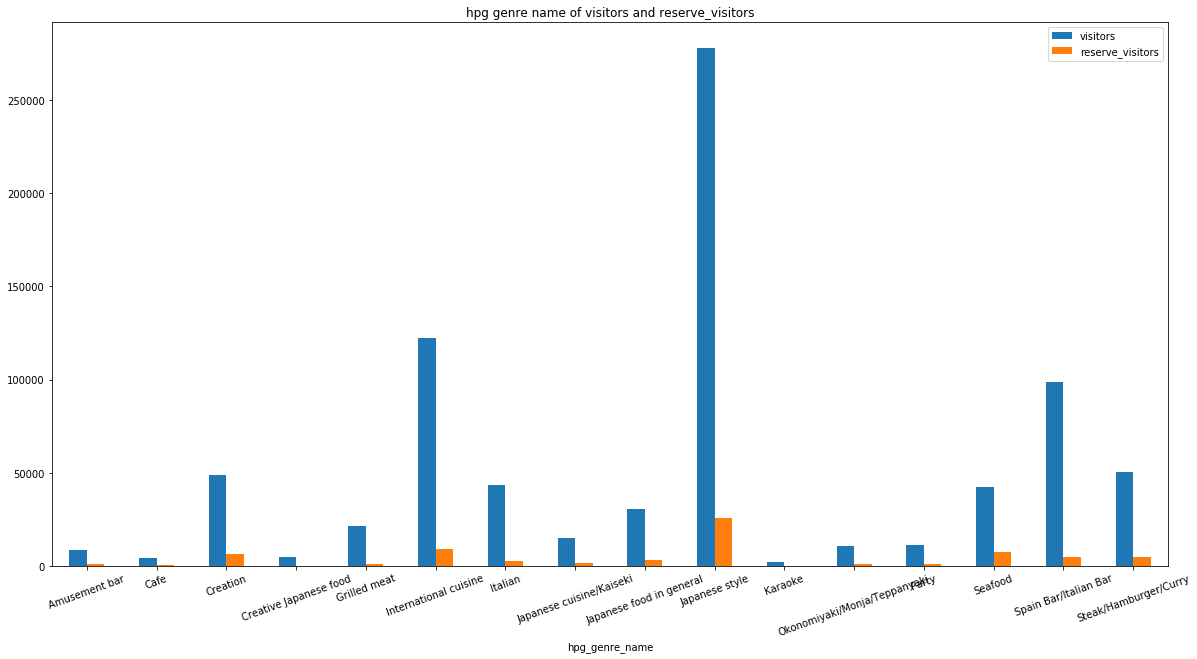

In [83]:
#hpgの料理ジャンル毎の客数、来客数
df = hpg_store_merge.groupby(["hpg_genre_name"])["visitors", "reserve_visitors"].sum().reset_index().set_index(["hpg_genre_name"])

df.plot.bar(figsize=(20, 10), rot=20)
plt.title("hpg genre name of visitors and reserve_visitors")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


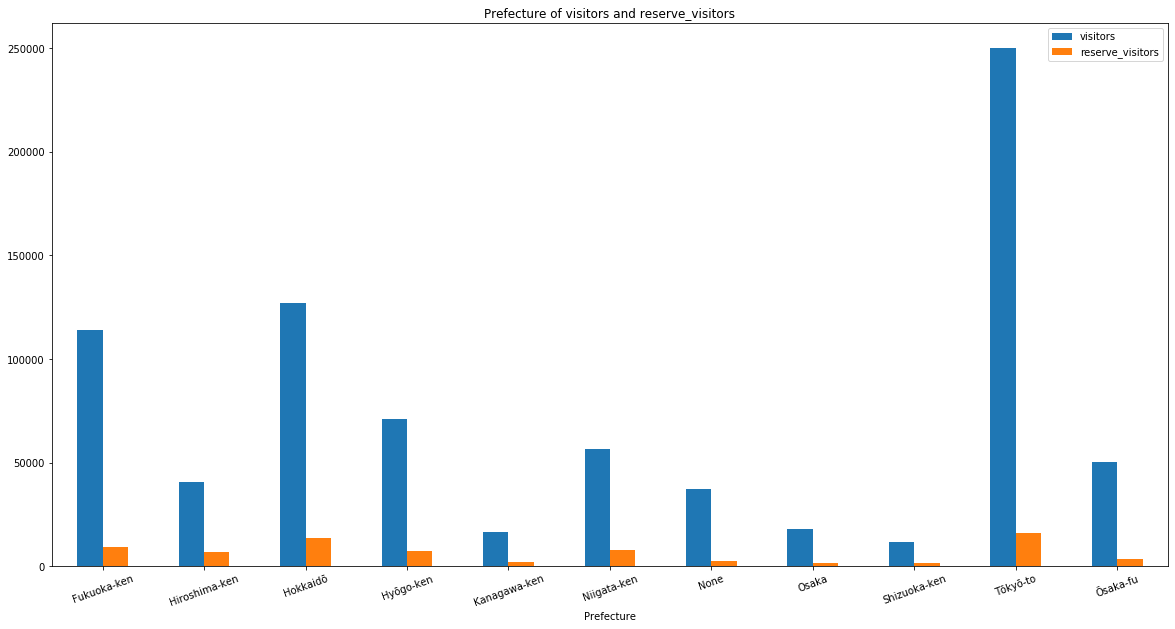

In [84]:
#hpgの市毎の予約者数、来客数
df = hpg_store_merge.groupby(["Prefecture"])["visitors", "reserve_visitors"].sum().reset_index().set_index(["Prefecture"])

df.plot.bar(figsize=(20, 10), rot=20)
plt.title("Prefecture of visitors and reserve_visitors")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


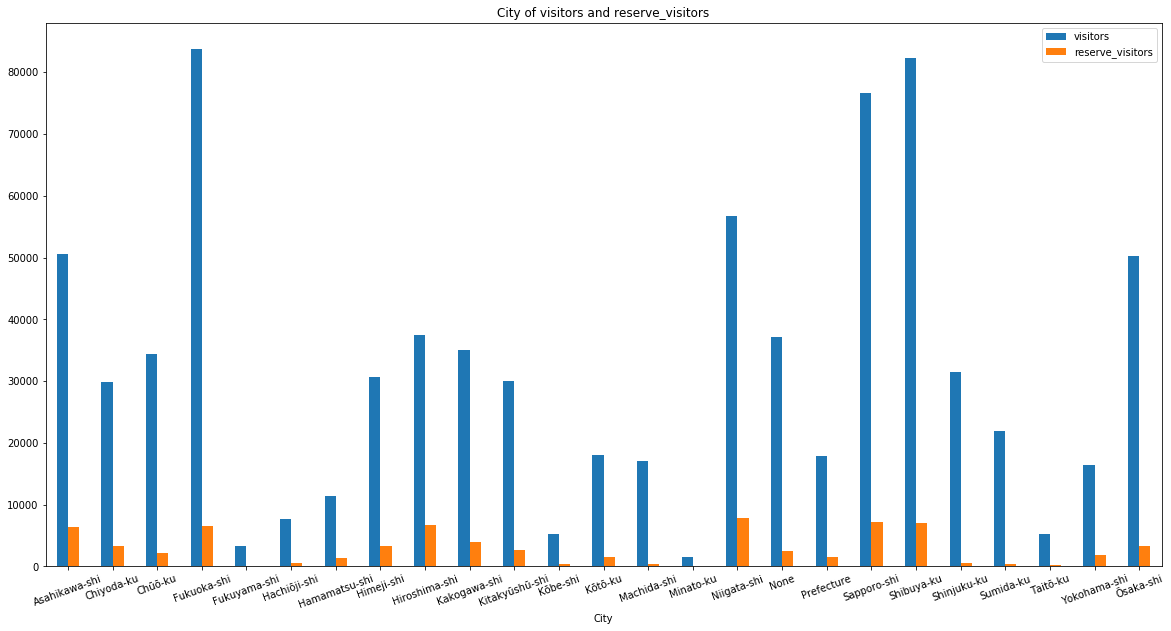

In [85]:
#hpgの町毎の予約者数、来客数
df = hpg_store_merge.groupby(["City"])["visitors", "reserve_visitors"].sum().reset_index().set_index(["City"])

df.plot.bar(figsize=(20, 10), rot=20)
plt.title("City of visitors and reserve_visitors")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


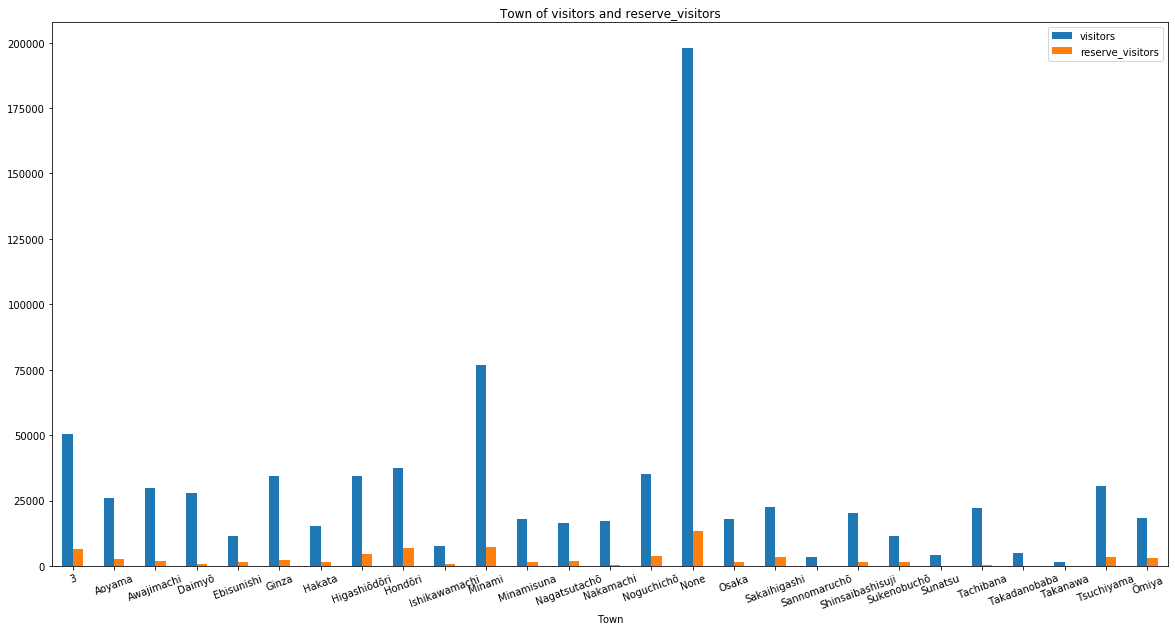

In [87]:
#hpgの村毎の予約者数、来客数
df = hpg_store_merge.groupby(["Town"])["visitors", "reserve_visitors"].sum().reset_index().set_index(["Town"])

df.plot.bar(figsize=(20, 10), rot=20)
plt.title("Town of visitors and reserve_visitors")
plt.show()

・推察

結果はair_visit_dataの時と予約者数、来客数の傾向は変わらない。

5.特徴量作成

In [90]:
print("air_reserve")
#air_reserveのデータ変換
air_reserve["visit_datetime"] = pd.to_datetime(air_reserve["visit_datetime"])
air_reserve["reserve_datetime"] = pd.to_datetime(air_reserve["reserve_datetime"])
#可視化の時と同じように年月日、曜日の特徴量を作成する
air_reserve["visit_date"] = pd.to_datetime(air_reserve["visit_datetime"]).dt.strftime("%Y-%m-%d")
air_reserve["visit_date"] = pd.to_datetime(air_reserve["visit_date"])
air_reserve["diff_visit"] = air_reserve["visit_datetime"] - air_reserve["reserve_datetime"]
air_reserve["diff_visit"] = air_reserve["diff_visit"].dt.days
air_reserve["year"] = pd.to_datetime(air_reserve["visit_datetime"]).dt.year
air_reserve["months"] = pd.to_datetime(air_reserve["visit_datetime"]).dt.month
air_reserve["day"] = pd.to_datetime(air_reserve["visit_datetime"]).dt.day
air_reserve["dow"] = pd.to_datetime(air_reserve["visit_datetime"]).dt.dayofweek

air_reserve


In [91]:
#air_reserveの予約者数の平均、最大、最小、合計、中央値、標準偏差
air_year = air_reserve.groupby(["air_store_id", "year"])["reserve_visitors"].agg(["mean", "max", "min", "sum", "median", "std"]).rename(columns={"mean":"re_year_mean", "max":"re_year_max", "min":"re_year_min", "sum":"re_year_sum", "median":"re_year_median", "std":"re_year_std"}).reset_index()
air_months = air_reserve.groupby(["air_store_id", "months"])["reserve_visitors"].agg(["mean", "max", "min", "sum", "median", "std"]).rename(columns={"mean":"re_months_mean", "max":"re_months_max", "min":"re_months_min", "sum":"re_months_sum", "median":"re_months_median", "std":"re_months_std"}).reset_index()
air_day = air_reserve.groupby(["air_store_id", "day"])["reserve_visitors"].agg(["mean", "max", "min", "sum", "median", "std"]).rename(columns={"mean":"re_day_mean", "max":"re_day_max", "min":"re_day_min", "sum":"re_day_sum", "median":"re_day_median", "std":"re_day_std"}).reset_index()
air_dow = air_reserve.groupby(["air_store_id", "dow"])["reserve_visitors"].agg(["mean", "max", "min", "sum", "median", "std"]).rename(columns={"mean":"re_dow_mean", "max":"re_dow_max", "min":"re_dow_min", "sum":"re_dow_sum", "median":"re_dow_median", "std":"re_dow_std"}).reset_index()
#diff_visitの合計と平均
air_r_sum = air_reserve.groupby(["air_store_id", "visit_date"])[["diff_visit", "reserve_visitors"]].sum().rename(columns={"diff_visit":"rs1", "reserve_visitors":"rv1"}).reset_index()
air_r_mean = air_reserve.groupby(["air_store_id", "visit_date"])[["diff_visit", "reserve_visitors"]].mean().rename(columns={"diff_visit":"rs2", "reserve_visitors":"rv2"}).reset_index()

hpg_reserveはairデータと結合できるよう、store_id_relationとマージさせる

In [93]:
#hpg_reserveとstore_id_relationをマージ
hpg_reserve = pd.merge(hpg_reserve, store_id_relation, on=["hpg_store_id"], how="inner")

In [94]:
#hpg_reserveも同じように年月日に変換
print("hpg_reserve")
hpg_reserve["visit_datetime"] = pd.to_datetime(hpg_reserve["visit_datetime"])
hpg_reserve["reserve_datetime"] = pd.to_datetime(hpg_reserve["reserve_datetime"])
hpg_reserve["visit_date"] = pd.to_datetime(hpg_reserve["visit_datetime"]).dt.strftime("%Y-%m-%d")
hpg_reserve["visit_date"] = pd.to_datetime(hpg_reserve["visit_date"])
hpg_reserve["diff_visit"] = hpg_reserve["visit_datetime"] - hpg_reserve["reserve_datetime"]
hpg_reserve["diff_visit"] = hpg_reserve["diff_visit"].dt.days
hpg_reserve["year"] = pd.to_datetime(hpg_reserve["visit_datetime"]).dt.year
hpg_reserve["months"] = pd.to_datetime(hpg_reserve["visit_datetime"]).dt.month
hpg_reserve["day"] = pd.to_datetime(hpg_reserve["visit_datetime"]).dt.day
hpg_reserve["dow"] = pd.to_datetime(hpg_reserve["visit_datetime"]).dt.dayofweek

hpg_reserve


In [95]:
#hpg_reserveの年月日毎のdiff_visitの合計と平均
hpg_r_sum = hpg_reserve.groupby(["air_store_id", "visit_date"])[["diff_visit", "reserve_visitors"]].sum().rename(columns={"diff_visit":"hpg_rs1", "reserve_visitors":"hpg_rv1"}).reset_index()
hpg_r_mean = hpg_reserve.groupby(["air_store_id", "visit_date"])[["diff_visit", "reserve_visitors"]].mean().rename(columns={"diff_visit":"hpg_rs2", "reserve_visitors":"hpg_rv2"}).reset_index()

air_visit_dataが目的変数があるので、このデータを軸にトレーニングデータを作成していく

In [96]:
#これも同様
print("air_visit_data")
air_visit_data["visit_date"] = pd.to_datetime(air_visit_data["visit_date"])
air_visit_data["year"] = air_visit_data["visit_date"].dt.year
air_visit_data["months"] = air_visit_data["visit_date"].dt.month
air_visit_data["day"] = air_visit_data["visit_date"].dt.day
air_visit_data["dow"] = air_visit_data["visit_date"].dt.dayofweek

air_visit_data


In [97]:
#air_visit_dataの予約者数の平均、最大、最小、合計、中央値、標準偏差
visit_year = air_visit_data.groupby(["air_store_id", "year"])["visitors"].agg(["mean", "max", "min", "sum", "median", "std"]).rename(columns={"mean":"year_mean", "max":"year_max", "min":"year_min", "sum":"year_sum", "median":"year_median", "std":"year_std"}).reset_index()
visit_months = air_visit_data.groupby(["air_store_id", "months"])["visitors"].agg(["mean", "max", "min", "sum", "median", "std"]).rename(columns={"mean":"months_mean", "max":"months_max", "min":"months_min", "sum":"months_sum", "median":"months_median", "std":"months_std"}).reset_index()
visit_day = air_visit_data.groupby(["air_store_id", "day"])["visitors"].agg(["mean", "max", "min", "sum", "median", "std"]).rename(columns={"mean":"day_mean", "max":"day_max", "min":"day_min", "sum":"day_sum", "median":"day_median", "std":"day_std"}).reset_index()
visit_dow = air_visit_data.groupby(["air_store_id", "dow"])["visitors"].agg(["mean", "max", "min", "sum", "median", "std"]).rename(columns={"mean":"dow_mean", "max":"dow_max", "min":"dow_min", "sum":"dow_sum", "median":"dow_median", "std":"dow_std"}).reset_index()

air_store_infoはair_area_nameを県と市に分割する。

市町村は同じ分けずに、市と同じとして考えてみる。村に該当する場所が少ないため、欠損値が存在してしまい、スコアに悪影響が出る可能性がある。

In [98]:
print("air_store_info")
air_store_info["Prefecture"] = air_store_info["air_area_name"].map(lambda x: str(x).split(' ')[0])
air_store_info["City"] = air_store_info["air_area_name"].map(lambda x:' '.join(x.split(' ')[1:]))

air_store_info


緯度、経度は変数同士の相互作用を表現する為、特徴量を合算、引き算してみる。

機械学習モデルが理解しやすいようにする。

In [99]:
#緯度、経度の合算
air_store_info["lati_long_sum"] = air_store_info["latitude"] + air_store_info["longitude"]
#緯度、経度の平均からどれほど離れているか
air_store_info["lati_m_diff"] = air_store_info["latitude"] - air_store_info["latitude"].mean()
air_store_info["long_m_diff"] = air_store_info["longitude"] - air_store_info["longitude"].mean()

In [100]:
print("date_info")
date_info["visit_date"] = pd.to_datetime(date_info["visit_date"])

date_info


In [101]:
#祝日に新たなフラグを立てる
#正月、ゴールデンウィーク、クリスマス
date_info["special_day"] = 0
def special_date(x):
    if x == "2016-01-01":
        return 1
    elif x == "2016-01-02":
        return 1
    elif x == "2016-01-03":
        return 1
    elif x == "2016-04-29":
        return 1
    elif x == "2016-04-30":
        return 1
    elif x == "2016-05-01":
        return 1
    elif x == "2016-05-02":
        return 1
    elif x == "2016-05-03":
        return 1
    elif x == "2016-05-04":
        return 1
    elif x == "2016-05-05":
        return 1
    elif x == "2016-05-06":
        return 1
    elif x == "2016-05-07":
        return 1
    elif x == "2016-05-08":
        return 1
    elif x == "2016-12-24":
        return 1
    elif x == "2016-12-25":
        return 1
    elif x == "2017-01-01":
        return 1
    elif x == "2017-01-02":
        return 1
    elif x == "2017-01-03":
        return 1
    elif x == "2017-04-29":
        return 1
    elif x == "2017-04-30":
        return 1
    else:
        return 0
    
date_info["special_day"] = date_info["visit_date"].apply(special_date)

そして休日の翌日も休日かどうか、休日の前日も休日かどうかをフラグ付けする

In [102]:
#holiday_flg2...休みの翌日と休みの日の前日をフラグ付けしている
date_info["holiday_flg2"] = pd.to_datetime(date_info["visit_date"]).dt.dayofweek
date_info["holiday_flg2"] = ((date_info["holiday_flg2"] > 4) | (date_info["holiday_flg"] == 1)).astype(int)

In [103]:
#store_idとvisit_dateが結合して,idの特徴量を成しているので分割する
sub["air_store_id"] = sub["id"].map(lambda x: '_'.join(x.split('_'))[:20])
sub["visit_date"] = sub["id"].map(lambda x: str(x).split('_')[2])
#年月日の抽出
sub["visit_date"] = pd.to_datetime(sub["visit_date"])
sub["year"] = pd.to_datetime(sub["visit_date"]).dt.year
sub["months"] = pd.to_datetime(sub["visit_date"]).dt.month
sub["day"] = pd.to_datetime(sub["visit_date"]).dt.day
sub["dow"] = pd.to_datetime(sub["visit_date"]).dt.dayofweek

In [104]:
#不必要な特徴量のため削除する
sub = sub.drop(["id", "visitors"], axis=1)

・新たな特徴量の作成

　店舗毎に特徴量を作成するために、一意な店舗データを取り出す

1.一意な店舗データを作り

2.そのデータに先程の特徴量をマージしていく

In [105]:
#air_store_idの一意なデータを取り出す
#データの圧縮
unique_store = sub["air_store_id"].unique()
#曜日の割り振り
unique_store = pd.concat([pd.DataFrame({'air_store_id': unique_store, 'dow': [i] * len(unique_store)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
#subの一意なair_store_idとreserve_visitorsの曜日特徴量の合算
unique_store = pd.merge(unique_store, air_dow, on=['air_store_id', 'dow'], how="left")
#air_store_infoのマージ
unique_store = pd.merge(unique_store, air_store_info.drop(["air_area_name"], axis=1), on=["air_store_id"], how="left")

6.トレーニングデータとテストデータの作成

先程作成した特徴量をair_visit_dataを軸にマージしていく

だが、これ全てを特徴量としたところ、スコアがかなり低くなったので特徴量選択を行った。

手順としては

1.作成した特徴量を全て学習させる。

2.一定以上の特徴量重要度を取り出し、再度それを学習させる。

3.2を繰り返し、スコアを算出しながらベストなところで止める。

結果として重要な特徴量は

In [106]:
#air_visit_dataとdate_infoのマージ
train = pd.merge(air_visit_data, date_info, on=["visit_date"], how="left")
#unique_store(air_store_idの一意のデータにreserve_visitorsの曜日の特徴量とair_store_infoのマージ)のマージ
train = pd.merge(train.drop(["day_of_week"], axis=1), unique_store, on=["air_store_id", "dow"], how="left")
#visit_dowのマージ
train = pd.merge(train, visit_dow, on=["air_store_id", "dow"], how="left")

In [107]:
#トレーニングデータと同じ特徴量にする
sub = pd.merge(sub, date_info.drop(["day_of_week"], axis=1), on=["visit_date"], how="left")
sub = pd.merge(sub, unique_store, on=["air_store_id", "dow"], how="left")
sub = pd.merge(sub, visit_dow, on=["air_store_id", "dow"], how="left")

カテゴリ変数の変換は分析モデルがGBDTなのでワンホットエンコーディングじゃなくラベルエンコーディングでも良い

In [108]:
cols = train.select_dtypes(include="object").columns
for i in cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[i].values))
    train[i] = lbl.transform(list(train[i].values))

cols = sub.select_dtypes(include="object").columns
for i in cols:
    lbl = LabelEncoder()
    lbl.fit(list(sub[i].values))
    sub[i] = lbl.transform(list(sub[i].values))

分析モデル　 Lightgbm

xgboostは決定木の分岐はLevel-wise だが LightgbmはLeaf-wiseにすることにより処理速度を向上させたモデル

In [109]:
import lightgbm as lgb

train = train.fillna(-1)
sub = sub.fillna(-1)

#目的変数とそれ以外とで分ける
#目的変数はnp.log1pにより正規分布にする
features = train.drop(["visit_date", "visitors"], axis=1)
target = np.log1p(train["visitors"])
test = sub.drop(["visit_date"], axis=1)

lgb_train = lgb.Dataset(features, target)

lgb_params = {
    "learning_rate":0.01,
    "objective":"regression",
    "boosting_type":"gbdt",
    "seed":71,
    "verbose":0,
    "metrics":"rmse"
}
num_round = 2000
watchlist = [lgb_train]

model = lgb.train(dict(lgb_params), lgb_train, num_boost_round=num_round, valid_sets=watchlist, early_stopping_rounds=30)

pred = model.predict(test)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


[1]	training's rmse: 0.803036
Training until validation scores don't improve for 30 rounds
[2]	training's rmse: 0.798415
[3]	training's rmse: 0.793859
[4]	training's rmse: 0.789369
[5]	training's rmse: 0.784941
[6]	training's rmse: 0.780579
[7]	training's rmse: 0.776277
[8]	training's rmse: 0.772039
[9]	training's rmse: 0.76786
[10]	training's rmse: 0.763742
[11]	training's rmse: 0.759686
[12]	training's rmse: 0.755687
[13]	training's rmse: 0.751746
[14]	training's rmse: 0.747863
[15]	training's rmse: 0.744039
[16]	training's rmse: 0.740266
[17]	training's rmse: 0.736553
[18]	training's rmse: 0.73289
[19]	training's rmse: 0.729281
[20]	training's rmse: 0.72573
[21]	training's rmse: 0.722229
[22]	training's rmse: 0.718785
[23]	training's rmse: 0.715388
[24]	training's rmse: 0.712046
[25]	training's rmse: 0.708753
[26]	training's rmse: 0.705511
[27]	training's rmse: 0.702316
[28]	training's rmse: 0.699169
[29]	training's rmse: 0.69607
[30]	training's rmse: 0.693023
[31]	training's rmse: 

[276]	training's rmse: 0.51448
[277]	training's rmse: 0.514414
[278]	training's rmse: 0.514358
[279]	training's rmse: 0.514297
[280]	training's rmse: 0.514235
[281]	training's rmse: 0.514178
[282]	training's rmse: 0.514122
[283]	training's rmse: 0.51406
[284]	training's rmse: 0.514001
[285]	training's rmse: 0.513943
[286]	training's rmse: 0.513888
[287]	training's rmse: 0.513829
[288]	training's rmse: 0.513771
[289]	training's rmse: 0.513718
[290]	training's rmse: 0.513662
[291]	training's rmse: 0.513609
[292]	training's rmse: 0.513558
[293]	training's rmse: 0.513501
[294]	training's rmse: 0.513445
[295]	training's rmse: 0.513396
[296]	training's rmse: 0.513348
[297]	training's rmse: 0.513297
[298]	training's rmse: 0.513244
[299]	training's rmse: 0.513196
[300]	training's rmse: 0.513151
[301]	training's rmse: 0.513101
[302]	training's rmse: 0.513056
[303]	training's rmse: 0.513009
[304]	training's rmse: 0.512964
[305]	training's rmse: 0.512914
[306]	training's rmse: 0.512862
[307]	trai

[550]	training's rmse: 0.50559
[551]	training's rmse: 0.50557
[552]	training's rmse: 0.50555
[553]	training's rmse: 0.505532
[554]	training's rmse: 0.505512
[555]	training's rmse: 0.505492
[556]	training's rmse: 0.505468
[557]	training's rmse: 0.505449
[558]	training's rmse: 0.505431
[559]	training's rmse: 0.505412
[560]	training's rmse: 0.50539
[561]	training's rmse: 0.505373
[562]	training's rmse: 0.505355
[563]	training's rmse: 0.505335
[564]	training's rmse: 0.505317
[565]	training's rmse: 0.505297
[566]	training's rmse: 0.505278
[567]	training's rmse: 0.505258
[568]	training's rmse: 0.505241
[569]	training's rmse: 0.505216
[570]	training's rmse: 0.505198
[571]	training's rmse: 0.505181
[572]	training's rmse: 0.505164
[573]	training's rmse: 0.50514
[574]	training's rmse: 0.505123
[575]	training's rmse: 0.505107
[576]	training's rmse: 0.505091
[577]	training's rmse: 0.505075
[578]	training's rmse: 0.505058
[579]	training's rmse: 0.505036
[580]	training's rmse: 0.505017
[581]	trainin

[822]	training's rmse: 0.501472
[823]	training's rmse: 0.501461
[824]	training's rmse: 0.501449
[825]	training's rmse: 0.50144
[826]	training's rmse: 0.501426
[827]	training's rmse: 0.501415
[828]	training's rmse: 0.501402
[829]	training's rmse: 0.501389
[830]	training's rmse: 0.501372
[831]	training's rmse: 0.501356
[832]	training's rmse: 0.50134
[833]	training's rmse: 0.501323
[834]	training's rmse: 0.501311
[835]	training's rmse: 0.501298
[836]	training's rmse: 0.50129
[837]	training's rmse: 0.501275
[838]	training's rmse: 0.501262
[839]	training's rmse: 0.501251
[840]	training's rmse: 0.50124
[841]	training's rmse: 0.501224
[842]	training's rmse: 0.501213
[843]	training's rmse: 0.501203
[844]	training's rmse: 0.50119
[845]	training's rmse: 0.501178
[846]	training's rmse: 0.501165
[847]	training's rmse: 0.501151
[848]	training's rmse: 0.501142
[849]	training's rmse: 0.501134
[850]	training's rmse: 0.501123
[851]	training's rmse: 0.501108
[852]	training's rmse: 0.501091
[853]	trainin

[1078]	training's rmse: 0.498593
[1079]	training's rmse: 0.498585
[1080]	training's rmse: 0.498576
[1081]	training's rmse: 0.498566
[1082]	training's rmse: 0.498555
[1083]	training's rmse: 0.498537
[1084]	training's rmse: 0.498527
[1085]	training's rmse: 0.498515
[1086]	training's rmse: 0.498509
[1087]	training's rmse: 0.498503
[1088]	training's rmse: 0.498492
[1089]	training's rmse: 0.498478
[1090]	training's rmse: 0.498466
[1091]	training's rmse: 0.498459
[1092]	training's rmse: 0.498452
[1093]	training's rmse: 0.498439
[1094]	training's rmse: 0.498427
[1095]	training's rmse: 0.498416
[1096]	training's rmse: 0.49841
[1097]	training's rmse: 0.498397
[1098]	training's rmse: 0.498388
[1099]	training's rmse: 0.498378
[1100]	training's rmse: 0.498372
[1101]	training's rmse: 0.498365
[1102]	training's rmse: 0.498355
[1103]	training's rmse: 0.498336
[1104]	training's rmse: 0.498325
[1105]	training's rmse: 0.498314
[1106]	training's rmse: 0.498305
[1107]	training's rmse: 0.498294
[1108]	trai

[1353]	training's rmse: 0.496217
[1354]	training's rmse: 0.496207
[1355]	training's rmse: 0.496197
[1356]	training's rmse: 0.496193
[1357]	training's rmse: 0.496189
[1358]	training's rmse: 0.496177
[1359]	training's rmse: 0.496172
[1360]	training's rmse: 0.496163
[1361]	training's rmse: 0.496159
[1362]	training's rmse: 0.496151
[1363]	training's rmse: 0.496146
[1364]	training's rmse: 0.496138
[1365]	training's rmse: 0.496124
[1366]	training's rmse: 0.496116
[1367]	training's rmse: 0.496112
[1368]	training's rmse: 0.496106
[1369]	training's rmse: 0.496092
[1370]	training's rmse: 0.496084
[1371]	training's rmse: 0.496077
[1372]	training's rmse: 0.496072
[1373]	training's rmse: 0.496063
[1374]	training's rmse: 0.496057
[1375]	training's rmse: 0.496052
[1376]	training's rmse: 0.496045
[1377]	training's rmse: 0.496037
[1378]	training's rmse: 0.496032
[1379]	training's rmse: 0.496021
[1380]	training's rmse: 0.496015
[1381]	training's rmse: 0.496012
[1382]	training's rmse: 0.496005
[1383]	tra

[1628]	training's rmse: 0.494069
[1629]	training's rmse: 0.494064
[1630]	training's rmse: 0.494058
[1631]	training's rmse: 0.494053
[1632]	training's rmse: 0.494046
[1633]	training's rmse: 0.494039
[1634]	training's rmse: 0.494031
[1635]	training's rmse: 0.494024
[1636]	training's rmse: 0.49402
[1637]	training's rmse: 0.49401
[1638]	training's rmse: 0.494002
[1639]	training's rmse: 0.493996
[1640]	training's rmse: 0.493991
[1641]	training's rmse: 0.493984
[1642]	training's rmse: 0.49397
[1643]	training's rmse: 0.493964
[1644]	training's rmse: 0.493959
[1645]	training's rmse: 0.493951
[1646]	training's rmse: 0.493944
[1647]	training's rmse: 0.493937
[1648]	training's rmse: 0.493926
[1649]	training's rmse: 0.493917
[1650]	training's rmse: 0.493911
[1651]	training's rmse: 0.493905
[1652]	training's rmse: 0.493899
[1653]	training's rmse: 0.493895
[1654]	training's rmse: 0.493888
[1655]	training's rmse: 0.493879
[1656]	training's rmse: 0.493875
[1657]	training's rmse: 0.493867
[1658]	traini

[1900]	training's rmse: 0.492184
[1901]	training's rmse: 0.492176
[1902]	training's rmse: 0.492173
[1903]	training's rmse: 0.492169
[1904]	training's rmse: 0.492164
[1905]	training's rmse: 0.49216
[1906]	training's rmse: 0.492154
[1907]	training's rmse: 0.492148
[1908]	training's rmse: 0.49214
[1909]	training's rmse: 0.492135
[1910]	training's rmse: 0.492127
[1911]	training's rmse: 0.492123
[1912]	training's rmse: 0.492118
[1913]	training's rmse: 0.492111
[1914]	training's rmse: 0.492102
[1915]	training's rmse: 0.492091
[1916]	training's rmse: 0.49208
[1917]	training's rmse: 0.492075
[1918]	training's rmse: 0.492068
[1919]	training's rmse: 0.492065
[1920]	training's rmse: 0.49206
[1921]	training's rmse: 0.492053
[1922]	training's rmse: 0.49205
[1923]	training's rmse: 0.492042
[1924]	training's rmse: 0.492039
[1925]	training's rmse: 0.49203
[1926]	training's rmse: 0.492028
[1927]	training's rmse: 0.492026
[1928]	training's rmse: 0.492015
[1929]	training's rmse: 0.492009
[1930]	training'

submit = pd.DataFrame()
submit["visitors"] = np.expm1(pred)
submit["id"] = sub["id"]
submit[['id', 'visitors']].to_csv(
    'recurit_restaurant.csv', index=False, float_format='%.3f')  
#Public_score...0.53800
#Private_score...0.51068

結果としてこの特徴量が一番スコアが高かった。

ちなみに他の特徴量では...

先の特徴量のdate_infoがない場合

Public_score...0.49935

Private_score...0.53862

air_yearを加えた場合

Public_score...0.49776

Private_score...0.54051


air_year,visit_yearの追加

Public_score...0.51886

Private_score...1.10683　　

などと特徴量を増やしていく毎にスコアが下がっていった。

ちなみに分析コンペにおいて重要なのはPrivate_scoreなので注意！

・総論

下手に特徴量を増やすたびににスコアが下がっていった。

Lightgbmといえど、ノイズとなる特徴量が多くともスコアに影響はないと思っていたが、
そうではないと今回のコンペティションで分かったので、過信は禁物。

時系列データへのアプローチの仕方や特徴量の削減等、良いスコアが出るよう良い特徴量を見つけるのが大変だった。

・課題

上手いバリデーションの方法を見つけることができなかったので、そこが課題。